# Problem Statement


In this notebook, we evelop a data-driven solution to identify anomalous patterns (within both
the covariates and the target metric in time series data) to detect and address outliers or irregularities effectively. We will explore different algorithms and explain how they work to solve the
problem.


In [9]:
!pip install pytrends seaborn
!pip install pyod
!pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.3-py3-none-any.whl size=190250 sha256=cad51b28398b32de56745879aa4d8b40bf20e0b9cfcd0dc78f34c2dc5f5d3704
  Stored in directory: /root/.cache/pip/wheels/05/f8/db/124d43bec122d6ec0ab3713fadfe25ebed8af52ec561682b4e
Successfully built pyod


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Description and Details from the [Kaggle Data Card](https://www.kaggle.com/competitions/acea-water-prediction):

The wells field of the alluvial plain between Ospedalicchio di Bastia Umbra and Petrignano is fed by three underground aquifers separated by low permeability septa. The aquifer can be considered a water table groundwater and is also fed by the Chiascio river. The groundwater levels are influenced by the following parameters: rainfall, depth to groundwater, temperatures and drainage volumes, level of the Chiascio river.


It is of the utmost importance to notice that some features like rainfall and temperature don’t go alongside the date. Indeed, both rainfall and temperature affect features like level, flow, depth to groundwater and hydrometry some time after it fell down. This means, for instance, that rain fell on 1st January doesn’t affect the mentioned features right the same day but some time later. As we don’t know how many days/weeks/months later rainfall affects these features, this is another aspect to keep into consideration when analyzing the dataset.

In [736]:
df = pd.read_csv("/content/Aquifer_Petrignano.csv")


In [737]:
df.describe()

Rainfall_Bastia_Umbra  Depth_to_Groundwater_P24  \
count            4199.000000               5168.000000   
mean                1.556633                -26.263723   
std                 5.217923                  3.319858   
min                 0.000000                -34.470000   
25%                 0.000000                -28.250000   
50%                 0.000000                -25.990000   
75%                 0.100000                -23.820000   
max                67.300000                -19.660000   

       Depth_to_Groundwater_P25  Temperature_Bastia_Umbra  \
count               5184.000000               4199.000000   
mean                 -25.692926                 15.030293   
std                    3.214165                  7.794871   
min                  -33.710000                 -3.700000   
25%                  -27.620000                  8.800000   
50%                  -25.540000                 14.700000   
75%                  -23.430000                 21.400000   
max                  -19.100000                 33.000000   

       Temperature_Petrignano  Volume_C10_Petrignano  \
count             4199.000000            5025.000000   
mean                13.739081          -29043.296726   
std                  7.701369            4751.864371   
min                 -4.200000          -45544.896000   
25%                  7.700000          -31678.560000   
50%                 13.500000          -28689.120000   
75%                 20.000000          -26218.080000   
max                 31.100000               0.000000   

       Hydrometry_Fiume_Chiascio_Petrignano  
count                           4199.000000  
mean                               2.372517  
std                                0.589088  
min                                0.000000  
25%                                2.100000  
50%                                2.400000  
75%                                2.700000  
max                                4.100000

In [738]:
from datetime import datetime, date

df['Date'] = pd.to_datetime(df['Date'])

<ipython-input-738-34986325136c>:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [739]:
df

Date  Rainfall_Bastia_Umbra  Depth_to_Groundwater_P24  \
0    2006-03-14                    NaN                    -22.48   
1    2006-03-15                    NaN                    -22.38   
2    2006-03-16                    NaN                    -22.25   
3    2006-03-17                    NaN                    -22.38   
4    2006-03-18                    NaN                    -22.60   
...         ...                    ...                       ...   
5218 2020-06-26                    0.0                    -25.68   
5219 2020-06-27                    0.0                    -25.80   
5220 2020-06-28                    0.0                    -25.80   
5221 2020-06-29                    0.0                    -25.78   
5222 2020-06-30                    0.0                    -25.91   

      Depth_to_Groundwater_P25  Temperature_Bastia_Umbra  \
0                       -22.18                       NaN   
1                       -22.14                       NaN   
2                       -22.04                       NaN   
3                       -22.04                       NaN   
4                       -22.04                       NaN   
...                        ...                       ...   
5218                    -25.07                      25.7   
5219                    -25.11                      26.2   
5220                    -25.19                      26.9   
5221                    -25.18                      26.9   
5222                    -25.25                      27.3   

      Temperature_Petrignano  Volume_C10_Petrignano  \
0                        NaN                    NaN   
1                        NaN                    NaN   
2                        NaN                    NaN   
3                        NaN                    NaN   
4                        NaN                    NaN   
...                      ...                    ...   
5218                    24.5             -29930.688   
5219                    25.0             -31332.960   
5220                    25.7             -32120.928   
5221                    26.0             -30602.880   
5222                    26.5             -31878.144   

      Hydrometry_Fiume_Chiascio_Petrignano  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN  
...                                    ...  
5218                                   2.5  
5219                                   2.4  
5220                                   2.4  
5221                                   2.4  
5222                                   2.4  

[5223 rows x 8 columns]

In [740]:
(df['Depth_to_Groundwater_P24'] - df['Depth_to_Groundwater_P25']).describe()

count    5157.000000
mean       -0.583861
std         0.248641
min        -1.270000
25%        -0.760000
50%        -0.600000
75%        -0.400000
max         0.230000
dtype: float64

In [741]:
(df['Temperature_Petrignano'] - df['Temperature_Bastia_Umbra']).describe()

count    4199.000000
mean       -1.291212
std         4.441673
min       -31.300000
25%        -0.900000
50%        -0.500000
75%        -0.200000
max         9.500000
dtype: float64

Depth_to_Groundwater_P24 and Depth_to_Groundwater_P25 are nearly the same, so we will keep only one of the two

In [742]:
df.drop('Depth_to_Groundwater_P24', inplace = True, axis=1)

In [743]:
df.columns

Index(['Date', 'Rainfall_Bastia_Umbra', 'Depth_to_Groundwater_P25',
       'Temperature_Bastia_Umbra', 'Temperature_Petrignano',
       'Volume_C10_Petrignano', 'Hydrometry_Fiume_Chiascio_Petrignano'],
      dtype='object')

In [744]:
df.columns = ['date', 'rainfall_bastia', 'depth_to_gw', 'temp_bastia', 'temp_pet',  'drainage_volume', 'hydrometry']

In [745]:
df

date  rainfall_bastia  depth_to_gw  temp_bastia  temp_pet  \
0    2006-03-14              NaN       -22.18          NaN       NaN   
1    2006-03-15              NaN       -22.14          NaN       NaN   
2    2006-03-16              NaN       -22.04          NaN       NaN   
3    2006-03-17              NaN       -22.04          NaN       NaN   
4    2006-03-18              NaN       -22.04          NaN       NaN   
...         ...              ...          ...          ...       ...   
5218 2020-06-26              0.0       -25.07         25.7      24.5   
5219 2020-06-27              0.0       -25.11         26.2      25.0   
5220 2020-06-28              0.0       -25.19         26.9      25.7   
5221 2020-06-29              0.0       -25.18         26.9      26.0   
5222 2020-06-30              0.0       -25.25         27.3      26.5   

      drainage_volume  hydrometry  
0                 NaN         NaN  
1                 NaN         NaN  
2                 NaN         NaN  
3                 NaN         NaN  
4                 NaN         NaN  
...               ...         ...  
5218       -29930.688         2.5  
5219       -31332.960         2.4  
5220       -32120.928         2.4  
5221       -30602.880         2.4  
5222       -31878.144         2.4  

[5223 rows x 7 columns]

In [746]:
df.isnull().sum()

date                  0
rainfall_bastia    1024
depth_to_gw          39
temp_bastia        1024
temp_pet           1024
drainage_volume     198
hydrometry         1024
dtype: int64

The first 1024 rows where all rainfall and temperature values are null, lets drop those, and plot the rest

In [747]:
df = df[df['temp_bastia'].notna()].reset_index(drop=True)

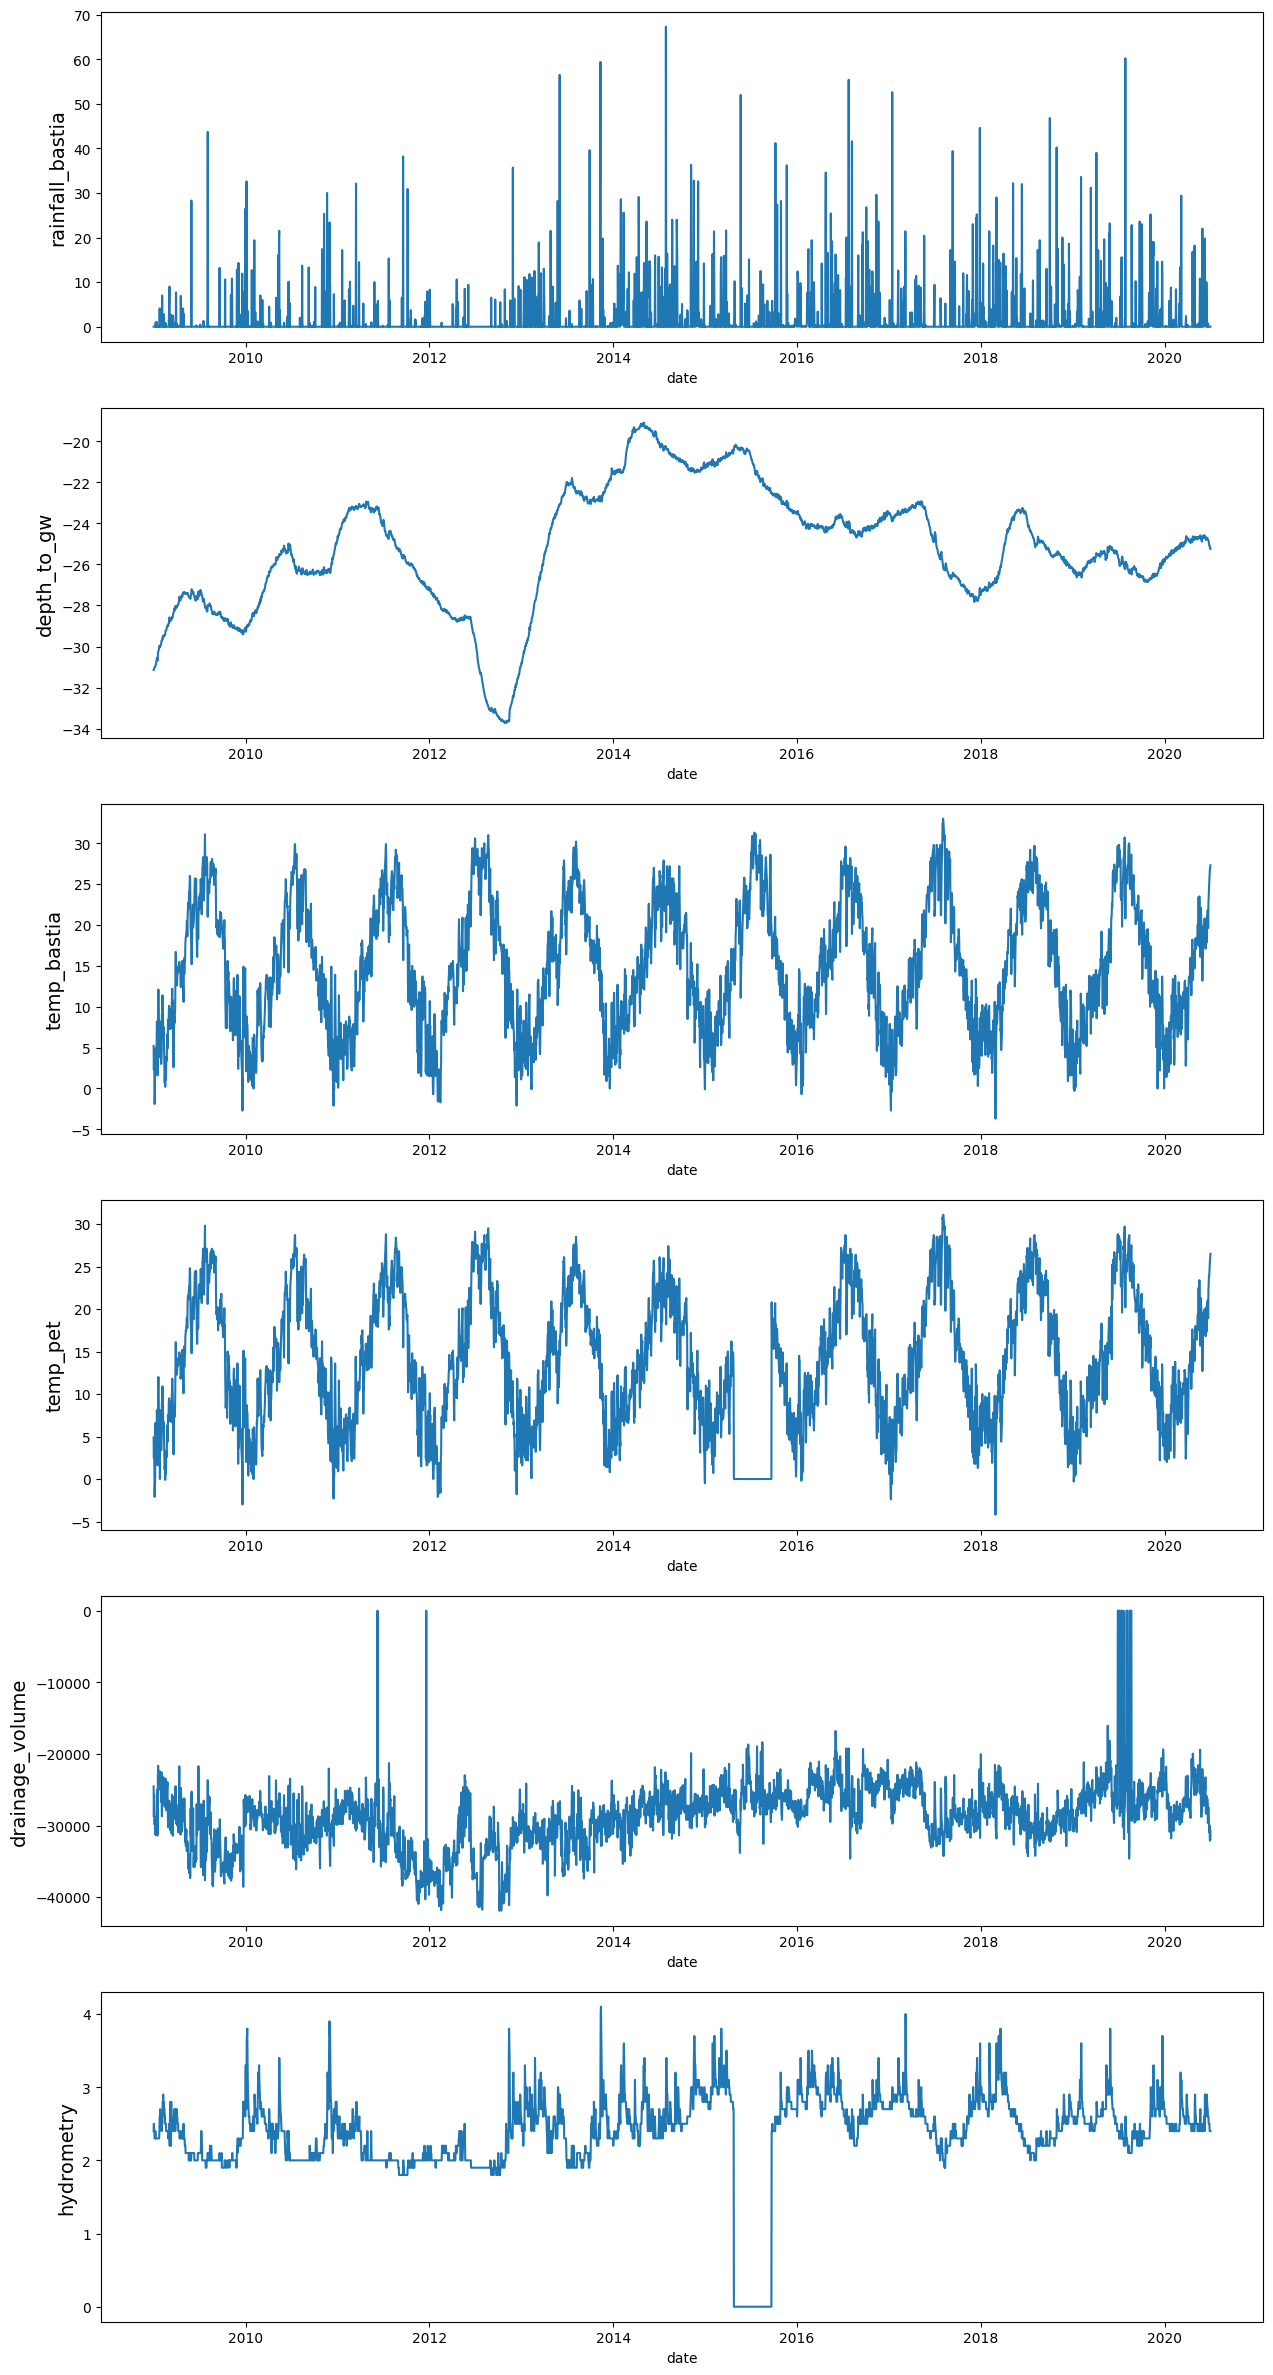

In [748]:
f, ax = plt.subplots(nrows=6, ncols=1, figsize=(15, 30))
i = 0
for column in df.columns[1:]:
    sns.lineplot(x=df['date'], y=df[column], ax=ax[i])
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    i+=1

In [749]:
temp_pet = df[['date', 'temp_pet']].set_index('date')

<Axes: xlabel='date'>

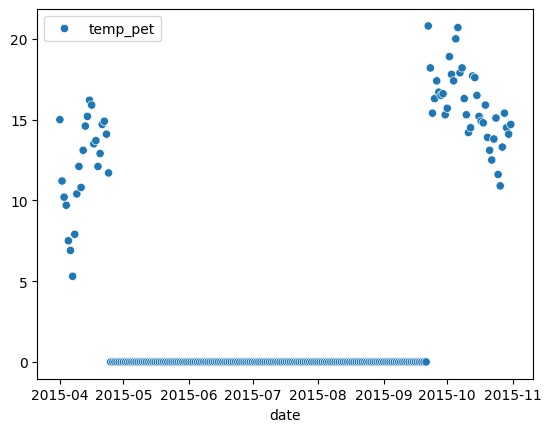

In [750]:



sns.scatterplot(temp_pet['April 2015':'Oct 2015'])

temp_pet, drainage_volume and hydrometry have obvious outliers/faulty data where the data = 0.
Assumptions:
* For drainage volume and hydrometry, the values are 0 only when the data is bad.
* For temp_pet, the faulty data is the string of 0's in 2015

The easiest way to identify them is to create a value = 0 filter for the relevant time span. However for the sake of this task, we will apply different methods to identify the corrupt data points and use the filter to verify if we were able to identify them correctly.

In [752]:
(temp_pet['April 2015':'Oct 2015']["temp_pet"] == 0).sum()


150

In [753]:
(df['drainage_volume'] == 0).sum()

25

In [754]:
(df['hydrometry'] == 0).sum()

150

Both temp_pet and hydrometry have the same 150 corrupt data points, whereas drainage_volume has 25. Lets now try and identify them using techniques


### Median Absolute Deviation (MAD)
The underlying assumption here is that the data is normally distributed, and the Z-score is the indicator of whether or not the point is an outlier. However since the outliers affect the mean, the computation of the Z-score uses the median instead of the Mean. If the score is over the threshold, the point id classified to be an outlier


$ MAD = \text{median}(|X_i - \text{median}(X)|) $




In [33]:
!pip install pyod

In [759]:
from pyod.models.mad import MAD

In [756]:

mad = MAD().fit(df[['temp_pet']])
mad_deviation =  df['temp_pet']
is_outlier = mad.labels_ == 1
print(len(df[is_outlier]))


0


This technique could not detetct the outliers in the data. This is because we see that the outliers are still in the normal range in the time series, i.e intuitively, they are not far from the median

Next, we will decompose the timeseries to identify seasonalities, trends and residuals. We can see the bad data impacting the trend and the residuals. We can use MAD on the residual data to identify outliers

Before we do the decomposition, lets ensure that the data points are at equal intervals. We see that the data is recorded at a daily frequency

In [757]:
 df = df.sort_values(by='date')
 delta = df['date'] - df['date'].shift(1)
 print(delta.value_counts())

date
1 days    4198
Name: count, dtype: int64


In [760]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [761]:
results = seasonal_decompose(df[['date', 'temp_pet']].set_index('date'), period = 365)

<Axes: xlabel='date'>

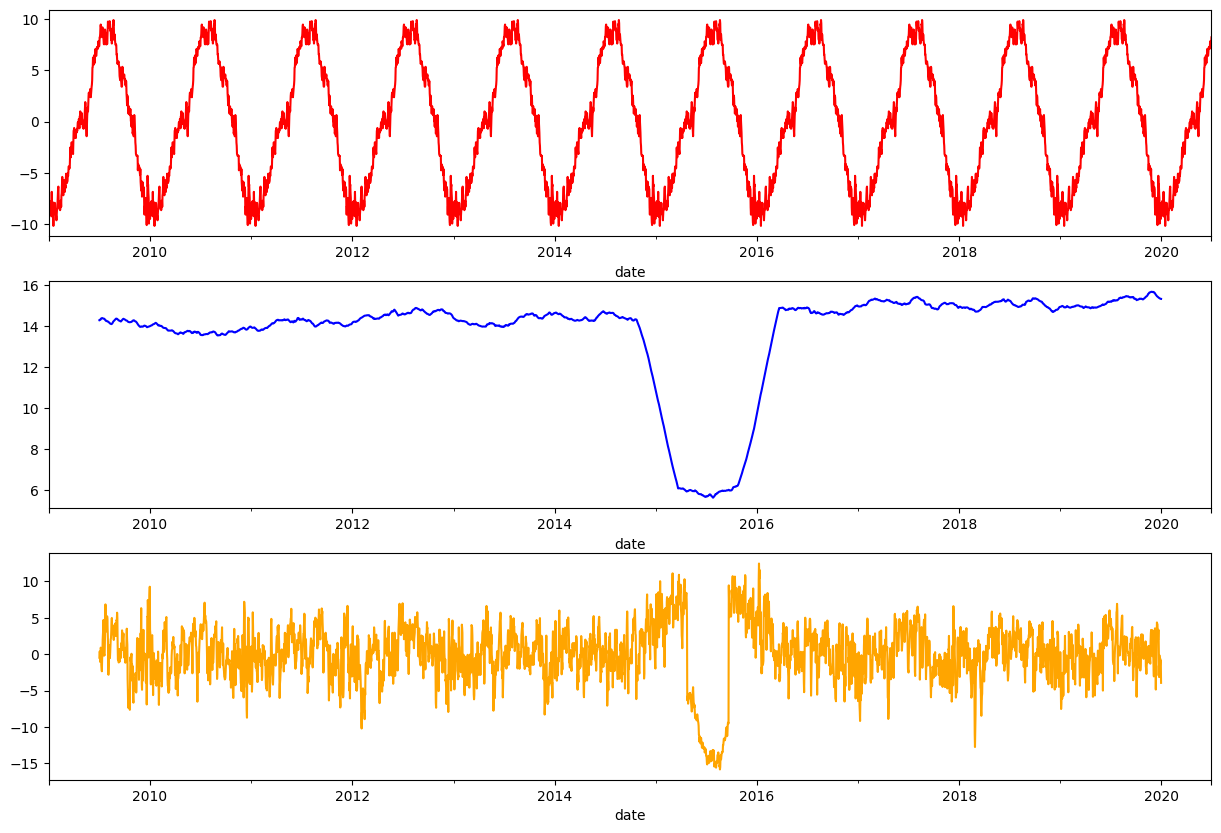

In [763]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 30))
results.seasonal.plot(color="red", figsize=(15, 10), ax=ax[0])
results.trend.plot(color="blue", figsize=(15, 10), ax=ax[1])
results.resid.plot(color="orange", figsize=(15, 10), ax=ax[2])

97


<Axes: xlabel='date', ylabel='temp_pet'>

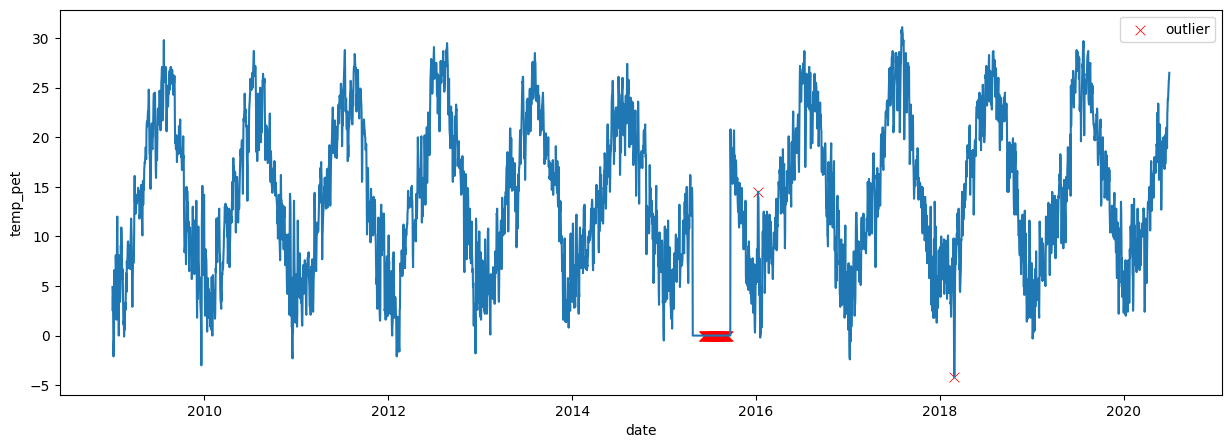

In [764]:
residuals = results.resid
residuals = residuals.values.reshape(-1, 1)
# Fit MAD
mad = MAD().fit(residuals)

# Find the outliers
is_outlier = mad.labels_ == 1
outliers_resids = df[is_outlier]
print(len(outliers_resids))

outlier_df = outliers_resids
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.lineplot(x=df['date'], y=df['temp_pet'])
sns.scatterplot(x=outlier_df['date'], y=df['temp_pet'], color = 'red', label = 'outlier', marker = 'x', s = 50, alpha = 1)


145


<Axes: xlabel='date', ylabel='temp_pet'>

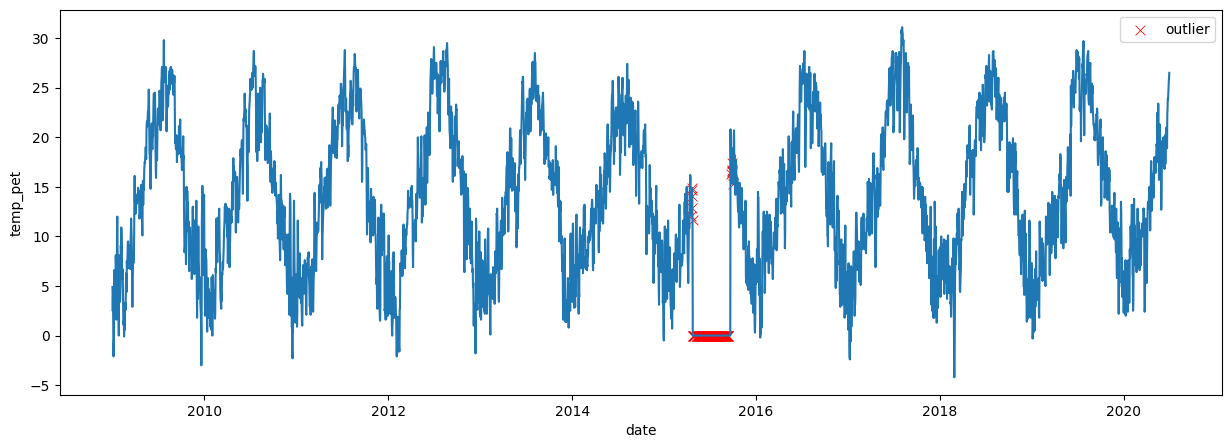

In [765]:
trends = results.trend
trends = trends.values.reshape(-1, 1)
# Fit MAD
mad = MAD(threshold = 12.5).fit(trends)
# Find the outliers
is_outlier = mad.labels_ == 1
outlier_trends = df[is_outlier]
print(len(outlier_trends))

outlier_df = outlier_trends
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.lineplot(x=df['date'], y=df['temp_pet'])
sns.scatterplot(x=outlier_df['date'], y=df['temp_pet'], color = 'red', label = 'outlier', marker = 'x', s = 50, alpha = 1)


<Axes: xlabel='date'>

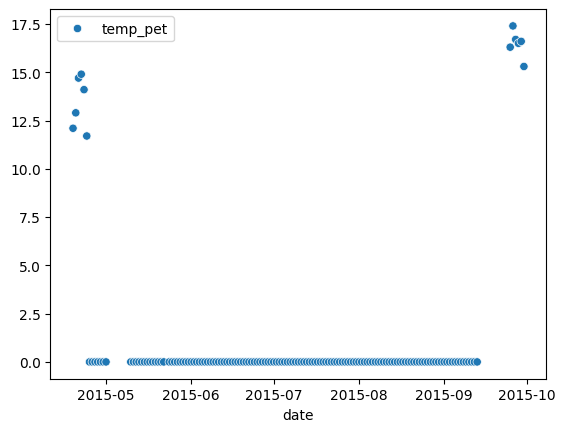

In [767]:

sns.scatterplot(outlier_trends[["date", "temp_pet"]].set_index("date"))

In [768]:
count = (outlier_trends["temp_pet"] == 0).sum()
total_zero  =(temp_pet['April 2015': 'Oct 2015']["temp_pet"] == 0).sum()



In [769]:
print (f"zero values identified: {count}. Percentage of zero values identified = {round(100*count/total_zero, 3)}" )

zero values identified: 133. Percentage of zero values identified = 88.667


We have successfully identified 88% of the bad outliers (with a few additional anomalies) using seasonal decomposition

32


<Axes: xlabel='date', ylabel='drainage_volume'>

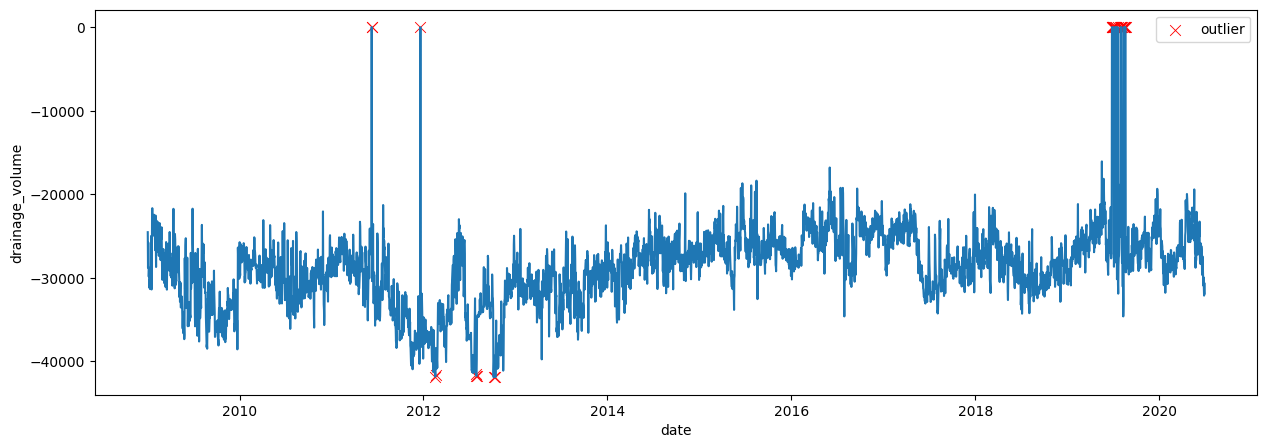

In [770]:
mad = MAD().fit(df[['drainage_volume']])
is_outlier = mad.labels_ == 1
print(len(df[is_outlier]))


outlier_drainage = df[is_outlier]
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.lineplot(x=df['date'], y=df['drainage_volume'])
sns.scatterplot(x=outlier_drainage['date'], y=df['drainage_volume'], color = 'red', label = 'outlier', s = 60, marker = 'x')


This detects the obvious outliers (the faulty data peaks), but also the extreme low values in 2012 which are anomalies. For now we are only interested in identifying the faulty data so we set the threshold higher. We do the same in hydrometry and set the threshold higher

25


<Axes: xlabel='date', ylabel='drainage_volume'>

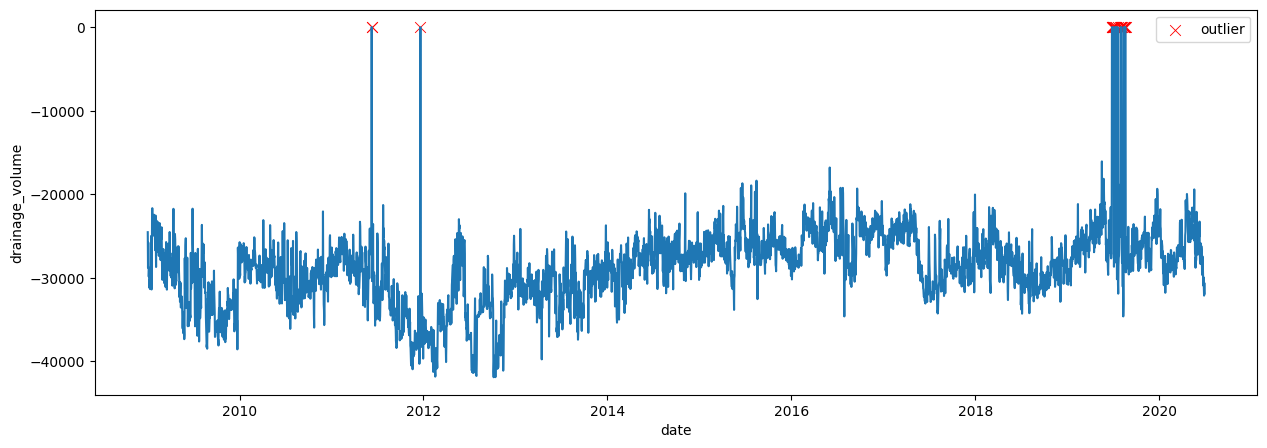

In [771]:
mad = MAD(threshold = 5).fit(df[['drainage_volume']])
is_outlier = mad.labels_ == 1
print(len(df[is_outlier]))


outlier_drainage = df[is_outlier]
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.lineplot(x=df['date'], y=df['drainage_volume'])
sns.scatterplot(x=outlier_drainage['date'], y=df['drainage_volume'], color = 'red', label = 'outlier', s = 60, marker = 'x')


The 25 points where the value waas 0 are detected

150


<Axes: xlabel='date', ylabel='hydrometry'>

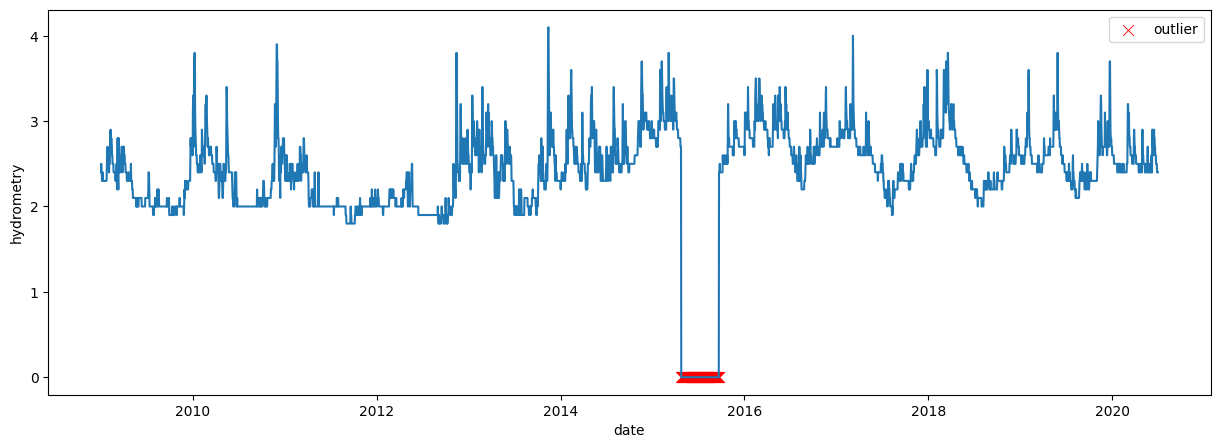

In [772]:
mad = MAD(threshold = 5).fit(df[['hydrometry']])
is_outlier = mad.labels_ == 1
print(len(df[is_outlier]))


outlier_hydro = df[is_outlier]
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.lineplot(x=df['date'], y=df['hydrometry'])
sns.scatterplot(x=outlier_hydro['date'], y=df['hydrometry'], color = 'red', label = 'outlier', s = 60, marker = 'x')

So far, we have attempted to find the corrupt data points. These points need to be treated before we do any further analysis. We will start by replacing the corrupt data with Null values. When dealing with time series, it is not advised to remove the null data points as it is with cross-sectional data. So we have to fill in the missing data

In [773]:
new_df = df.copy()

In [774]:
len(outlier_drainage)

25

In [775]:
len(outlier_hydro)

150

In [51]:
len(outlier_trends)

145

In [776]:
new_df["hydrometry"] = np.where(
    new_df["date"].isin(outlier_hydro['date']),
    None,
    new_df["hydrometry"]
)

In [777]:
new_df["drainage_volume"] = np.where(
    new_df["date"].isin(outlier_drainage['date']),
    None,
    new_df["drainage_volume"]
)

In [778]:
new_df["temp_pet"] = np.where(
    new_df["date"].isin(outlier_trends['date']),
    None,
    new_df["temp_pet"]
)

In [779]:
null_dict = dict(new_df.isna().sum())
null_dict

{'date': 0,
 'rainfall_bastia': 0,
 'depth_to_gw': 27,
 'temp_bastia': 0,
 'temp_pet': 145,
 'drainage_volume': 26,
 'hydrometry': 150}

In [780]:
null_features = [column for column in new_df.columns if null_dict[column]>0]

Let's fill in the missing/null values using some of the techniques  [here](https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7)

In [781]:
null_features


['depth_to_gw', 'temp_pet', 'drainage_volume', 'hydrometry']

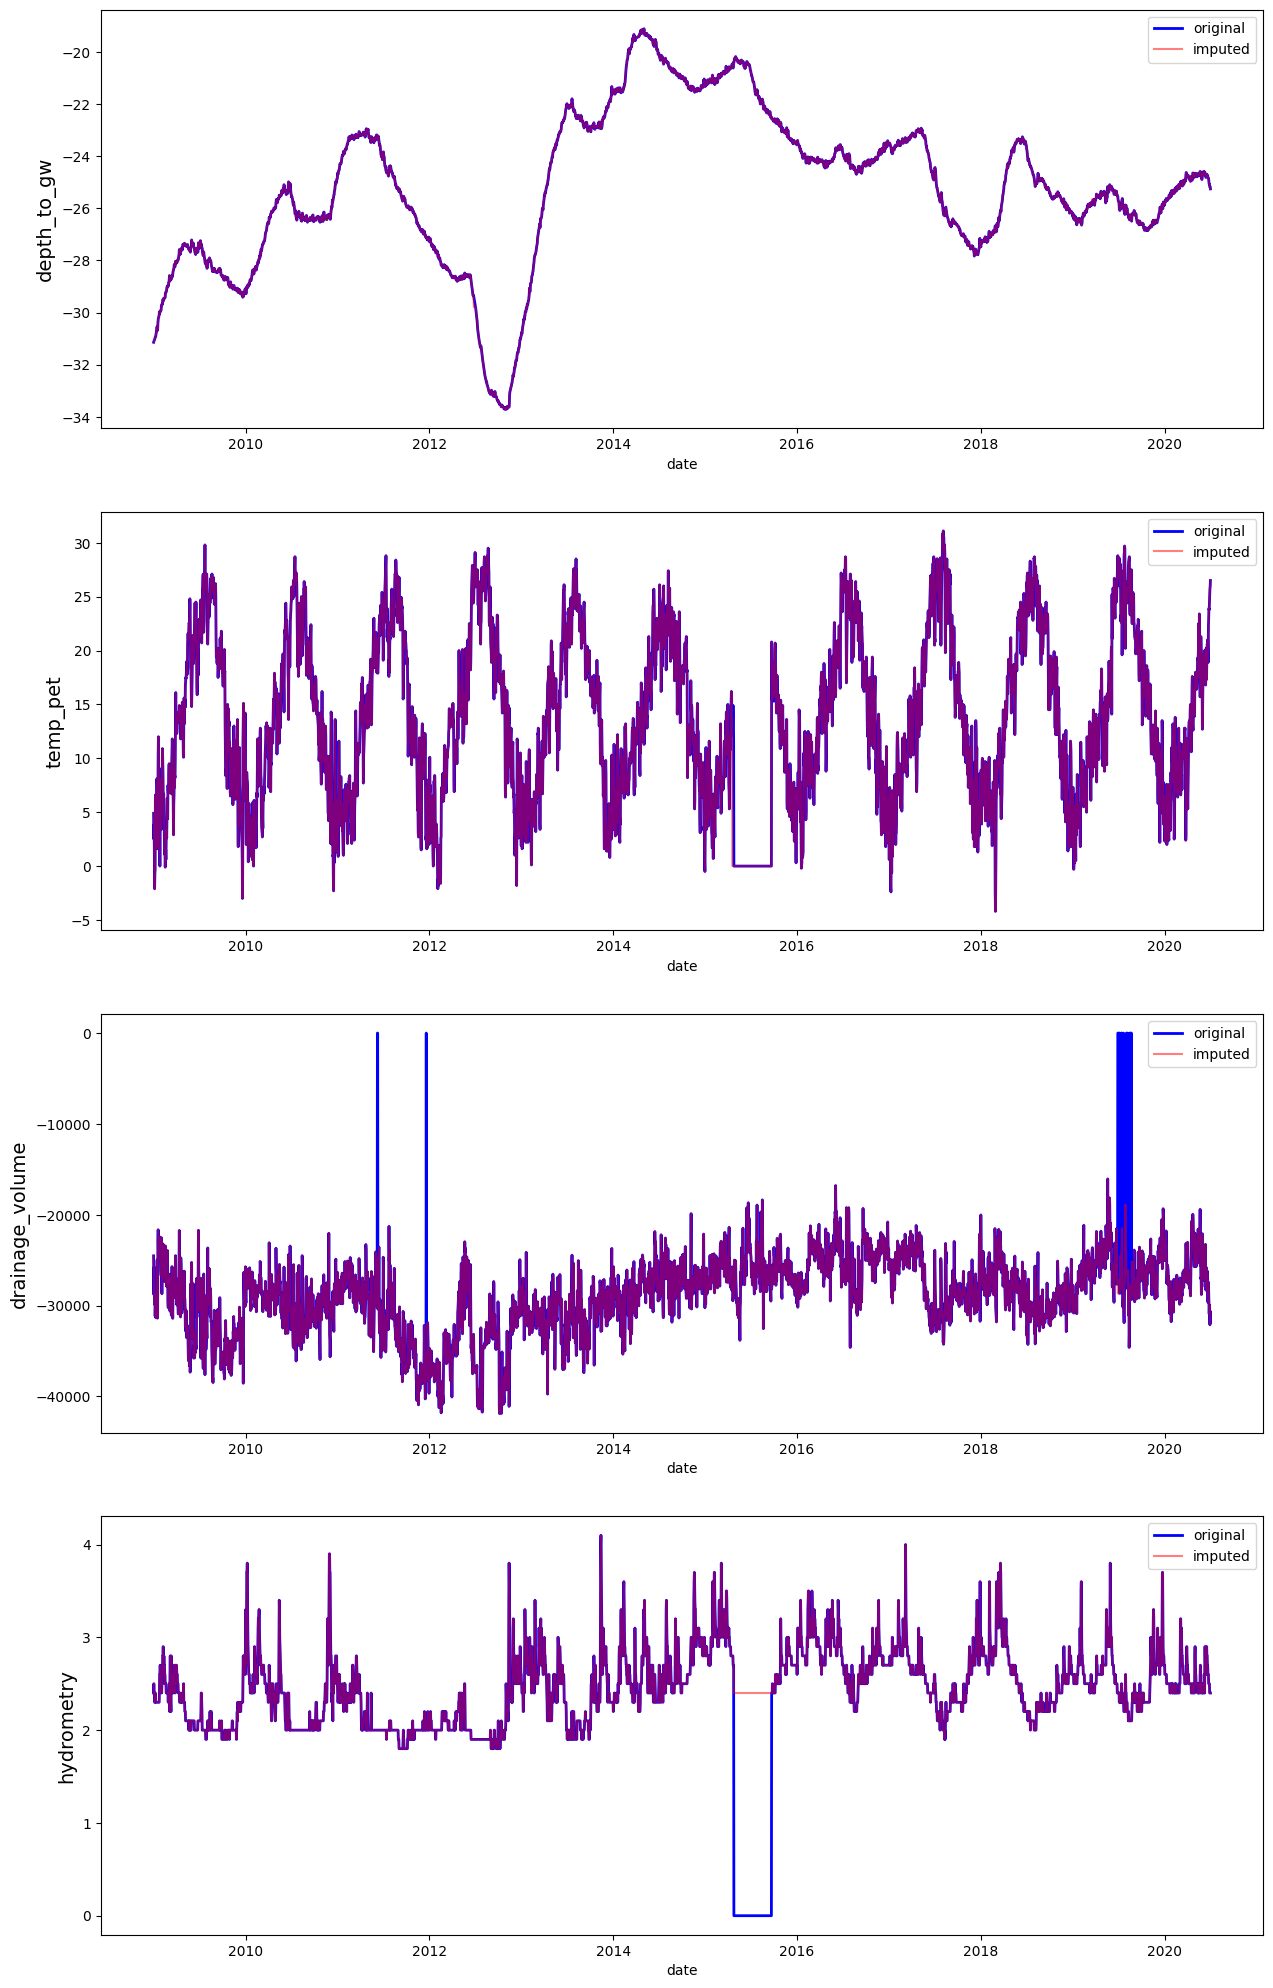

In [783]:
##NOCB Next Observation Carried Backward
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))
i = 0
for column in null_features:
    sns.lineplot(x=df['date'], y=df[column], ax=ax[i], color = 'blue', label = 'original', lw = 2)
    sns.lineplot(x=df['date'], y=new_df[column].fillna(method = 'bfill'), ax=ax[i], color='red', label = 'imputed', alpha = 0.5)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    i+=1


plt.show()

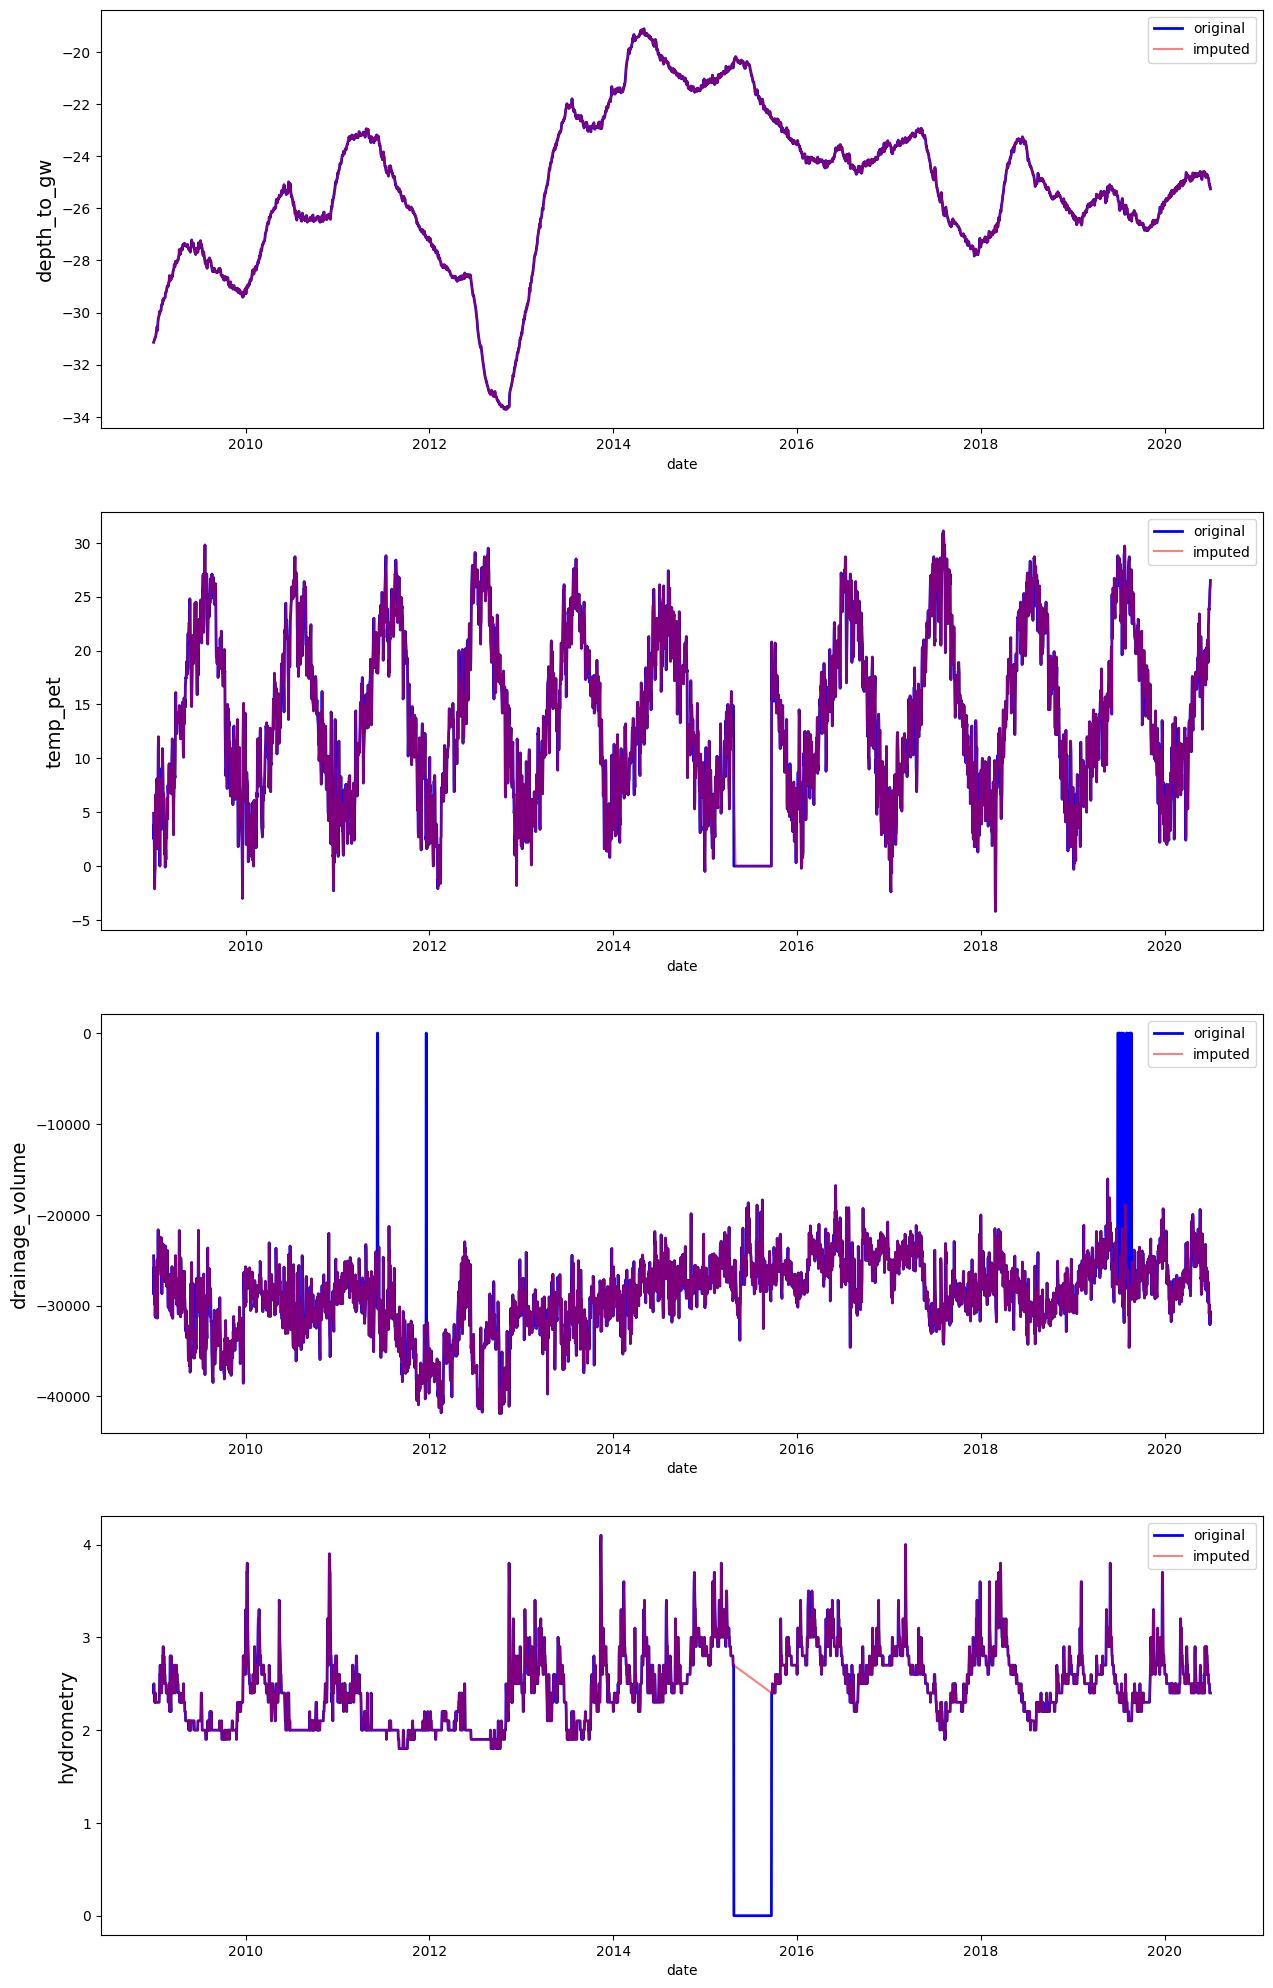

In [785]:
##interpolation
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))
i = 0
for column in null_features:
    sns.lineplot(x=df['date'],  y=df[column], ax=ax[i], color = 'blue', label = 'original', lw = 2 )
    sns.lineplot(x=df['date'], y=new_df[column].interpolate(), ax=ax[i], color='red', label = 'imputed', alpha = 0.5)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    i+=1


In [786]:
new_df['depth_to_gw_interpolated'] = new_df['depth_to_gw'].interpolate()
new_df['drainage_volume_interpolated'] = new_df['drainage_volume'].interpolate()

In [787]:
new_df['depth_to_gw_interpolated'].isna().sum()

0

In [788]:
new_df['drainage_volume_interpolated'].isna().sum()

26

In [789]:
new_df['drainage_volume_ffill'] = new_df['drainage_volume'].fillna(method = 'ffill')

In [790]:
new_df['drainage_volume_ffill'].isna().sum()

0

In [791]:
a.isna().sum()

26

#STL Data Imputation

The methods above work reasonaly well for drainage_volume and depth_to_gw but not for hydrometry and temp_pet. We will impute the missing data by leveraging the seasonality (STL imputation) for hydrometry and temp_pet

In [792]:
df.isna().sum()


date                0
rainfall_bastia     0
depth_to_gw        27
temp_bastia         0
temp_pet            0
drainage_volume     1
hydrometry          0
dtype: int64

In [793]:
new_df.isna().sum()

date                              0
rainfall_bastia                   0
depth_to_gw                      27
temp_bastia                       0
temp_pet                        145
drainage_volume                  26
hydrometry                      150
depth_to_gw_interpolated          0
drainage_volume_interpolated     26
drainage_volume_ffill             0
dtype: int64

In [794]:
#df: original df
#new_df: all detected outlier zero values are null

#Note the original df has no null values in temp_pet

In [795]:
df_copy = new_df.copy()

<Axes: xlabel='date'>

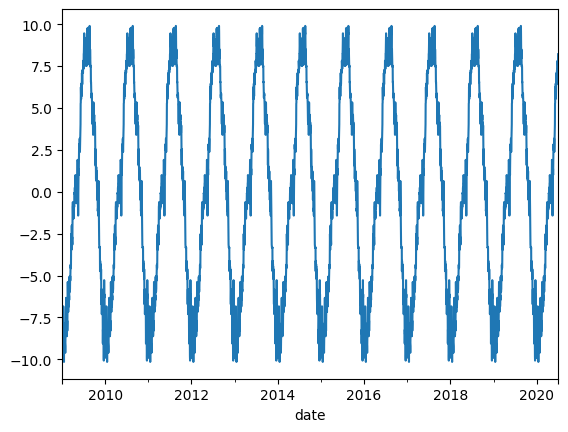

In [796]:
results = seasonal_decompose(df[['date', 'temp_pet']].set_index('date'), period = 365)
seasonal_component = results.seasonal
seasonal_component.plot()

<Axes: xlabel='date'>

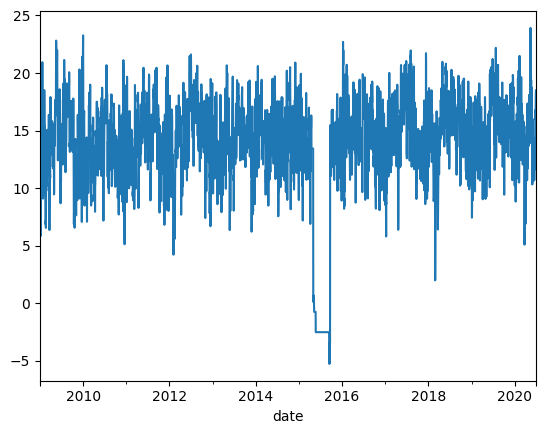

In [797]:
# Create the deseasonalised series
df_deseasonalised =  df_copy[['date', 'temp_pet']].set_index('date')['temp_pet'] - seasonal_component

# Fill missing values in the deseasonalised series
df_deseasonalised_imputed = df_deseasonalised.fillna(method = 'ffill')
df_deseasonalised_imputed.plot()

<Axes: xlabel='date'>

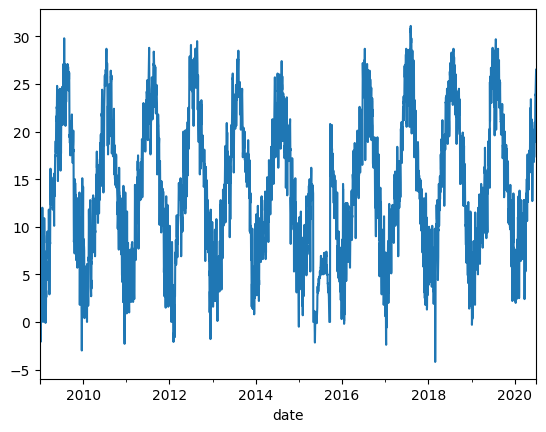

In [798]:
# Add the seasonal component back to create the final imputed series
df_imputed = df_deseasonalised_imputed + seasonal_component
df_imputed.plot()

This timeseries was obtained by:
* Subtracting the seasonal component of the original from the new_df (with missing data) to obtain a deseasonalized series.
* The missing data in the deseasonalized series was filled in by the last observation carried forward (LOCF)
* The seasonal component was added back to the deseasonalized series

We are only interested in the imputed data where the values are null

In [799]:
# Fill missing values in the time series
df_imputed = df_imputed.reset_index(drop= True)
imputed_indices = df_copy[df_copy['temp_pet'].isnull()].index

df_copy.loc[imputed_indices, 'temp_pet'] = df_imputed[imputed_indices]

<Axes: xlabel='date', ylabel='temp_pet'>

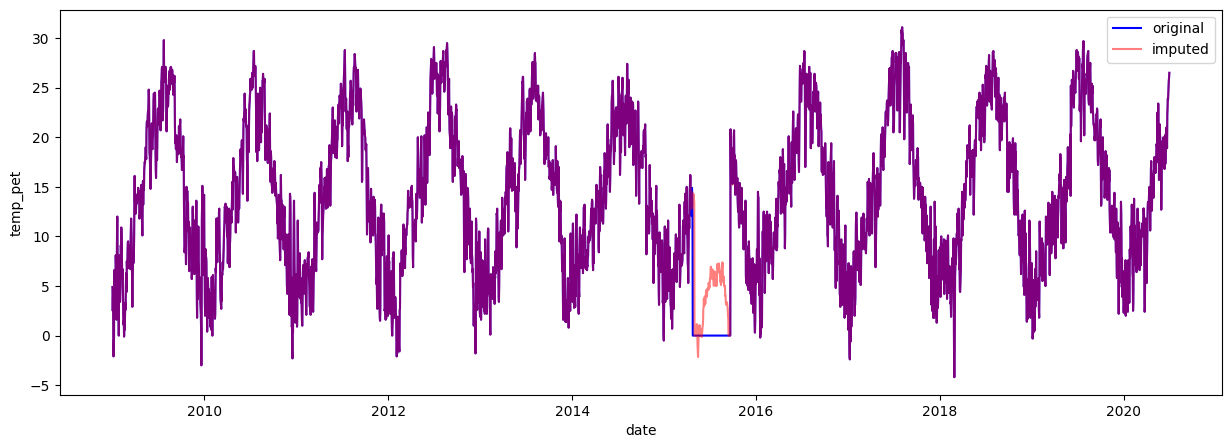

In [800]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=df['date'],  y=df['temp_pet'],  color = 'blue', label = 'original')
sns.lineplot(x=df['date'], y=df_copy['temp_pet'],color='red', label = 'imputed', alpha = 0.5)

In [801]:
new_df["temp_pet_seasonal_decomp"] = df_copy["temp_pet"]

So we discover that this technique works much better for cases with repeated missing/faulty data. Lets repeat the same process for hydrometry

<Axes: xlabel='date'>

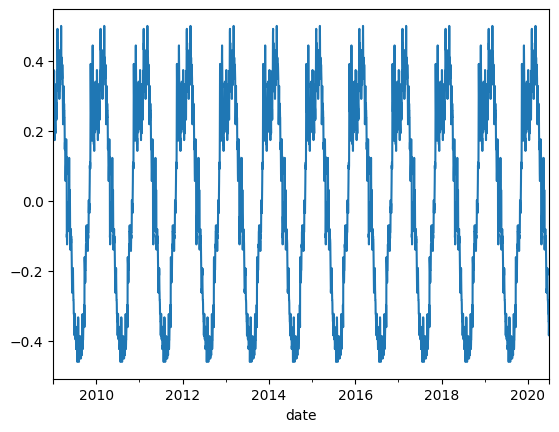

In [802]:
results = seasonal_decompose(df[['date', 'hydrometry']].set_index('date'), period = 365)
seasonal_component = results.seasonal
seasonal_component.plot()

<Axes: xlabel='date'>

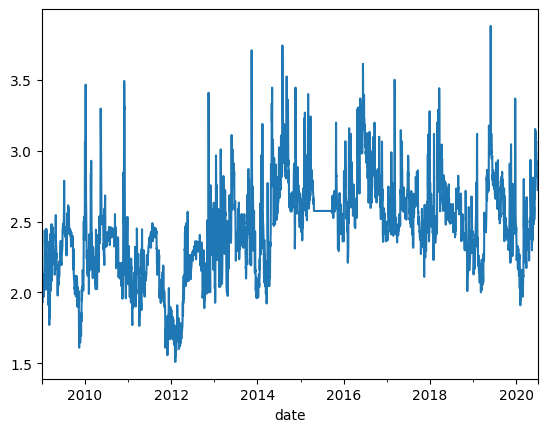

In [803]:
# Create the deseasonalised series
df_deseasonalised =  df_copy[['date', 'hydrometry']].set_index('date')['hydrometry'] - seasonal_component

# Fill missing values in the deseasonalised series
df_deseasonalised_imputed = df_deseasonalised.fillna(method = 'ffill')
df_deseasonalised_imputed.plot()

<Axes: xlabel='date'>

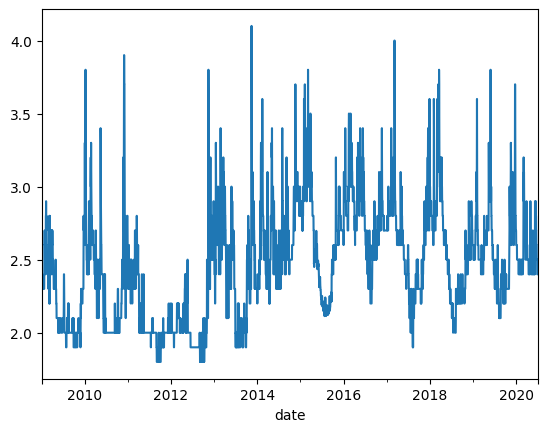

In [804]:
# Add the seasonal component back to create the final imputed series
df_imputed = df_deseasonalised_imputed + seasonal_component
df_imputed.plot()

In [805]:
# Fill missing values in the time series
df_imputed = df_imputed.reset_index(drop= True)
imputed_indices = df_copy[df_copy['hydrometry'].isnull()].index

df_copy.loc[imputed_indices, 'hydrometry'] = df_imputed[imputed_indices]


<Axes: xlabel='date', ylabel='hydrometry'>

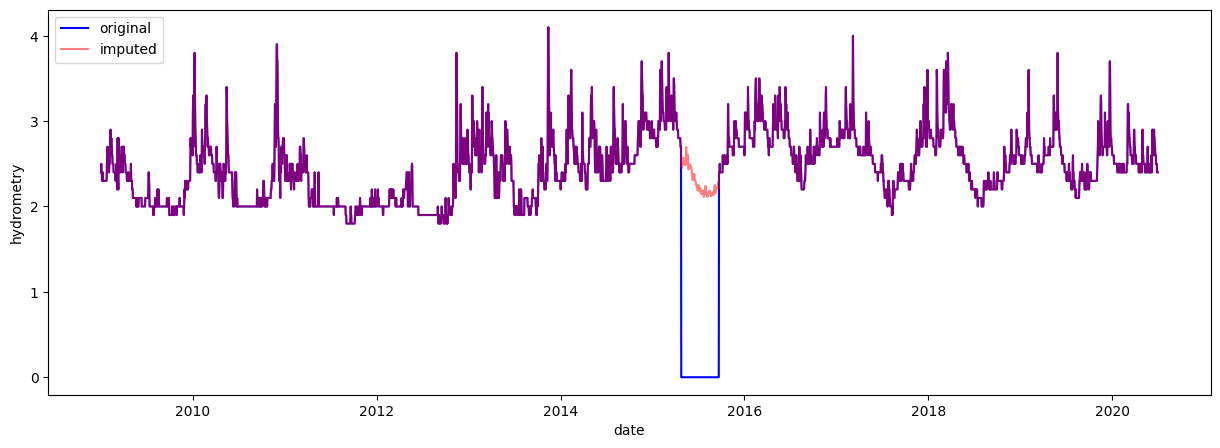

In [806]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=df['date'],  y=df['hydrometry'],  color = 'blue', label = 'original')
sns.lineplot(x=df['date'], y=df_copy['hydrometry'],color='red', label = 'imputed', alpha = 0.5)

In [807]:
new_df["hydrometry_seasonal_decomp"] = df_copy["hydrometry"]

###Using [Facebooks Prophet Model](https://facebook.github.io/prophet/) to reconstruct the time series and fill in the null values

In [808]:
from prophet import Prophet
def prediction_prophet(feature, df):
  df_prophet = pd.DataFrame()
  df_prophet['ds'] = pd.to_datetime(df['date'],  dayfirst = True)
  df_prophet.reset_index(drop=True, inplace=True)
  df_prophet['y'] = df[[feature]]
  m = Prophet(yearly_seasonality=True)
  m.fit(df_prophet)
  future = m.make_future_dataframe(periods=1)
  forecast = m.predict(future)
  return forecast,m

In [809]:
forecast,m = prediction_prophet('temp_pet', df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp498x7ro7/0om96t_7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp498x7ro7/oqt53c4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2187', 'data', 'file=/tmp/tmp498x7ro7/0om96t_7.json', 'init=/tmp/tmp498x7ro7/oqt53c4v.json', 'output', 'file=/tmp/tmp498x7ro7/prophet_model3rg1zobq/prophet_model-20240510074956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


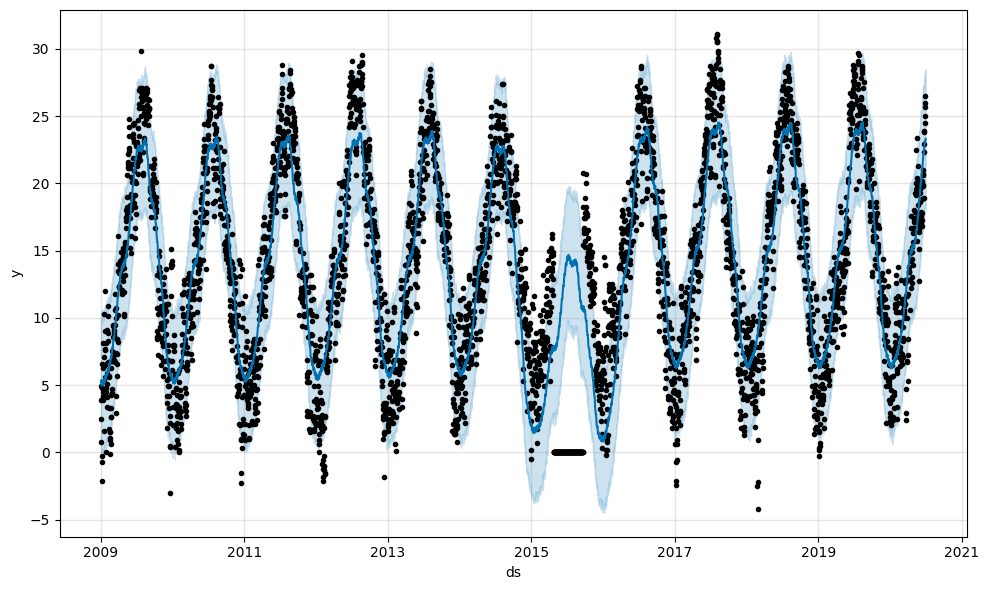

In [810]:
fig = m.plot(forecast)

<Axes: xlabel='date', ylabel='temp_pet'>

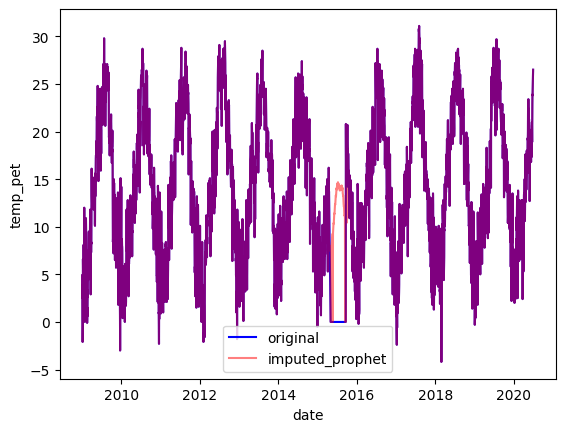

In [811]:
imputed_indices = new_df[new_df['temp_pet'].isnull()].index
new_df['temp_pet_prophet'] = new_df['temp_pet']
new_df.loc[imputed_indices, 'temp_pet_prophet'] = forecast['yhat'][imputed_indices]

sns.lineplot(x=df['date'],  y=new_df['temp_pet'],  color = 'blue', label = 'original')
sns.lineplot(x=new_df['date'], y=new_df['temp_pet_prophet'] ,color='red', label = 'imputed_prophet', alpha = 0.5)

The predicted data points using Prophet and Seasonal Decomposition vary. Lets compare the temp_pet to temp_bastia, which is the temperature of another region x distance away.




In [812]:
new_df['temp_bastia'].isna().sum()

0

<Axes: xlabel='date', ylabel='temp_bastia'>

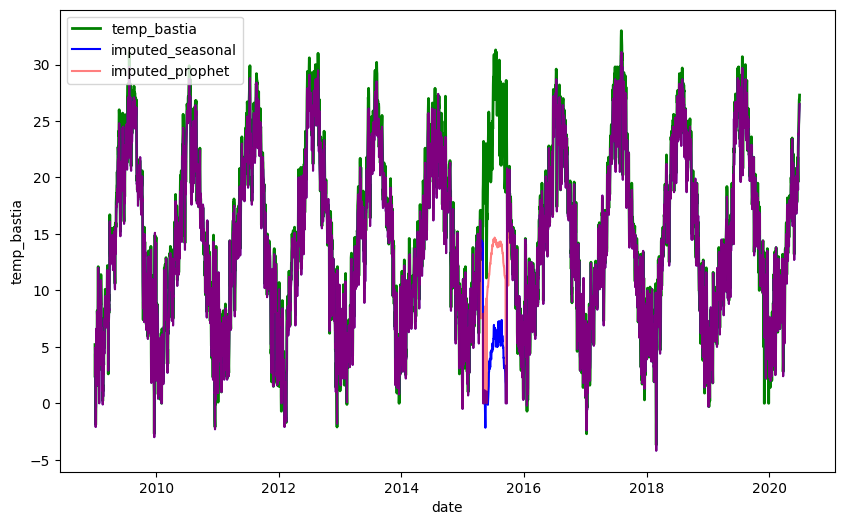

In [813]:
f, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=df['date'],  y=new_df['temp_bastia'],  color = 'green', label = 'temp_bastia', lw=2)
sns.lineplot(x=df['date'],  y=new_df['temp_pet_seasonal_decomp'],  color = 'blue', label = 'imputed_seasonal')
sns.lineplot(x=df['date'], y=new_df['temp_pet_prophet'] , color='red', label = 'imputed_prophet', alpha = 0.5)


(16526.0, 16709.0)

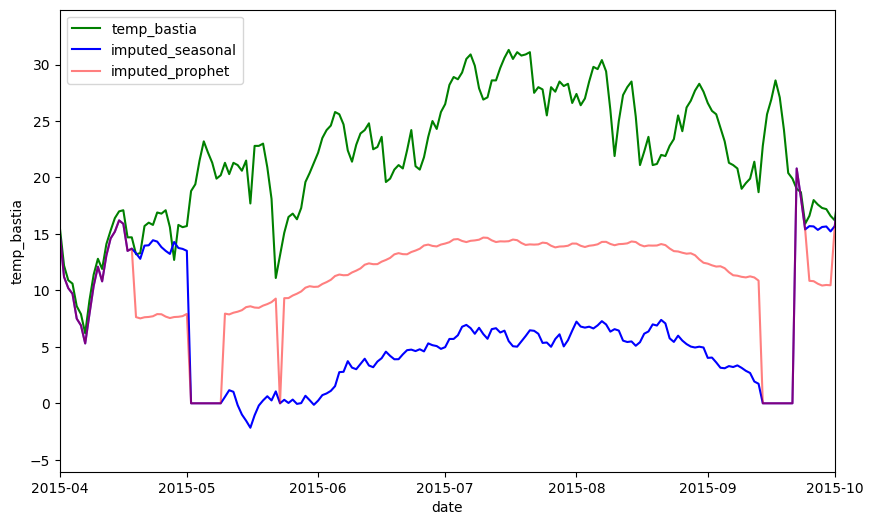

In [814]:
#zooming in
f, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=df['date'],  y=new_df['temp_bastia'],  color = 'green', label = 'temp_bastia')
sns.lineplot(x=df['date'],  y=new_df['temp_pet_seasonal_decomp'],  color = 'blue', label = 'imputed_seasonal')
sns.lineplot(x=df['date'], y=new_df['temp_pet_prophet'] , color='red', label = 'imputed_prophet', alpha = 0.5)


ax.set_xlim([date(2015, 4, 1), date(2015, 10, 1)])

In [815]:
#prophet
new_df['temp_bastia'].corr(new_df['temp_pet_seasonal_decomp'].astype(float))

0.8816318747718854

In [816]:
#seasonal decomposition
new_df['temp_bastia'].corr(new_df['temp_pet_prophet'].astype(float))

0.9448911852746684

Both imputation techniques follow the pattern of temp_bastia, however, Prophet has a higher correlation with temp_bastia. To make the prophet model even better, lets add in temp_bastia as a regressor.

In [817]:
from prophet import Prophet
def prediction_multi_prophet(features, target,  df):
  df_prophet = pd.DataFrame()
  df_prophet['ds'] = pd.to_datetime(df['date'])
  df_prophet.reset_index(drop=True, inplace=True)
  df_prophet['y'] = df[target]
  m = Prophet()
  for i in features:
    df_prophet[i] = df[i]
    m.add_regressor(i)

  m.fit(df_prophet)
  future = m.make_future_dataframe(periods=1)
  for i in features:
    future[i] = df[i]
  future = future.dropna()
  forecast = m.predict(future)

  return forecast,m

In [818]:
forecast,m = prediction_multi_prophet(['temp_bastia'], 'temp_pet', new_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp498x7ro7/7iddg7rg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp498x7ro7/1b5a25oq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85394', 'data', 'file=/tmp/tmp498x7ro7/7iddg7rg.json', 'init=/tmp/tmp498x7ro7/1b5a25oq.json', 'output', 'file=/tmp/tmp498x7ro7/prophet_modelrz5ag04l/prophet_model-20240510075038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:50:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:50:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


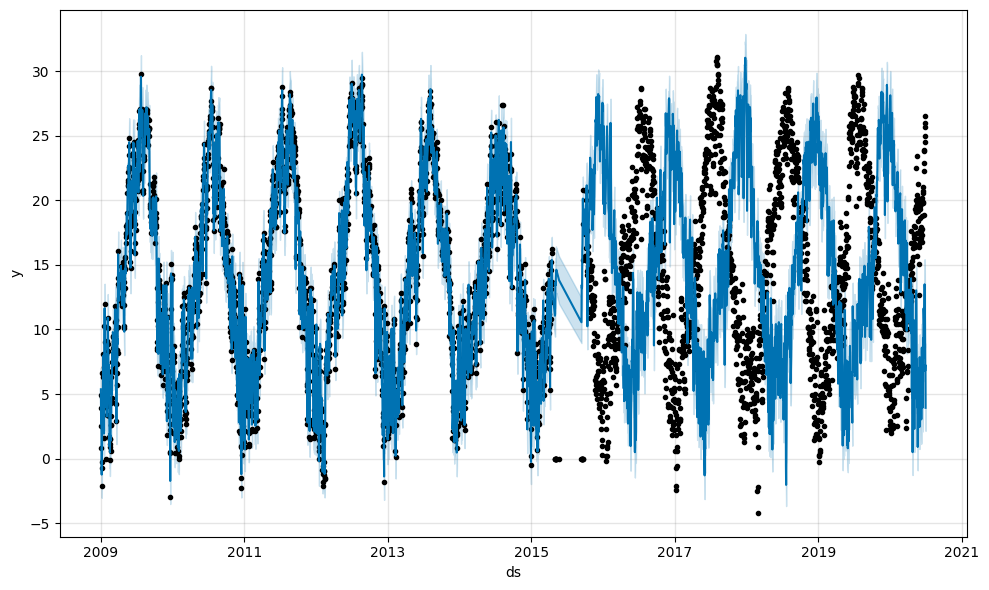

In [819]:
fig = m.plot(forecast)

<Axes: xlabel='date', ylabel='temp_pet_multi_prophet'>

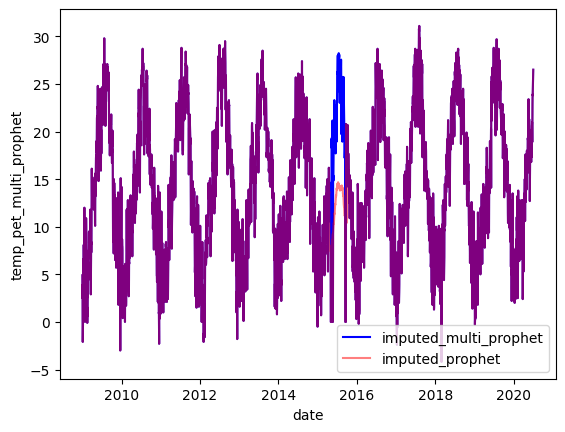

In [820]:
imputed_indices = new_df[new_df['temp_pet'].isnull()].index
new_df['temp_pet_multi_prophet'] = new_df['temp_pet']
new_df.loc[imputed_indices, 'temp_pet_multi_prophet'] = forecast['yhat'][imputed_indices]

sns.lineplot(x=df['date'],  y=new_df['temp_pet_multi_prophet'],  color = 'blue', label = 'imputed_multi_prophet')
sns.lineplot(x=new_df['date'], y=new_df['temp_pet_prophet'] ,color='red', label = 'imputed_prophet', alpha = 0.5)

(16526.0, 16709.0)

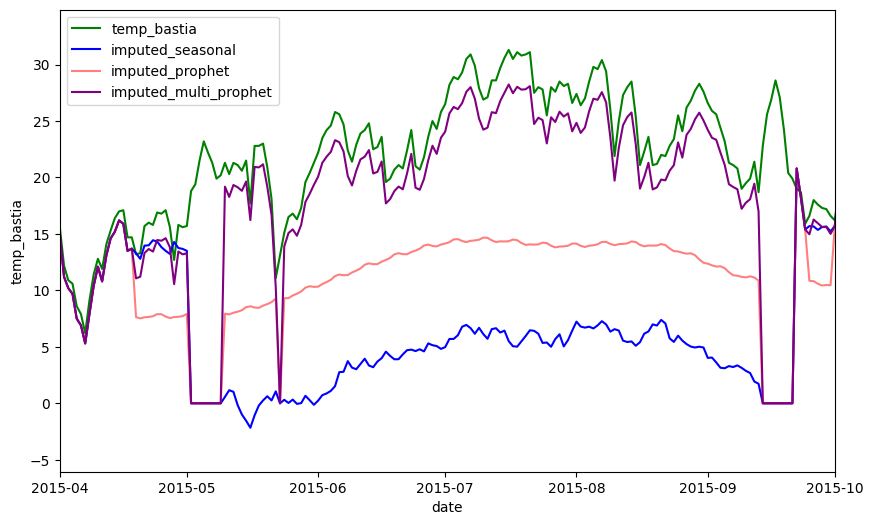

In [821]:
#zooming in
f, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=df['date'],  y=new_df['temp_bastia'],  color = 'green', label = 'temp_bastia')
sns.lineplot(x=df['date'],  y=new_df['temp_pet_seasonal_decomp'],  color = 'blue', label = 'imputed_seasonal')
sns.lineplot(x=df['date'], y=new_df['temp_pet_prophet'] , color='red', label = 'imputed_prophet', alpha = 0.5)
sns.lineplot(x=df['date'],  y=new_df['temp_pet_multi_prophet'],  color = 'purple', label = 'imputed_multi_prophet')

ax.set_xlim([date(2015, 4, 1), date(2015, 10, 1)])

In [822]:
#prophet
new_df['temp_bastia'].corr(new_df['temp_pet_multi_prophet'].astype(float))

0.9799253361077663

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp498x7ro7/9lg3qkdy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp498x7ro7/y8tbel_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30025', 'data', 'file=/tmp/tmp498x7ro7/9lg3qkdy.json', 'init=/tmp/tmp498x7ro7/y8tbel_s.json', 'output', 'file=/tmp/tmp498x7ro7/prophet_model03mmm471/prophet_model-20240510075102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:51:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:51:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


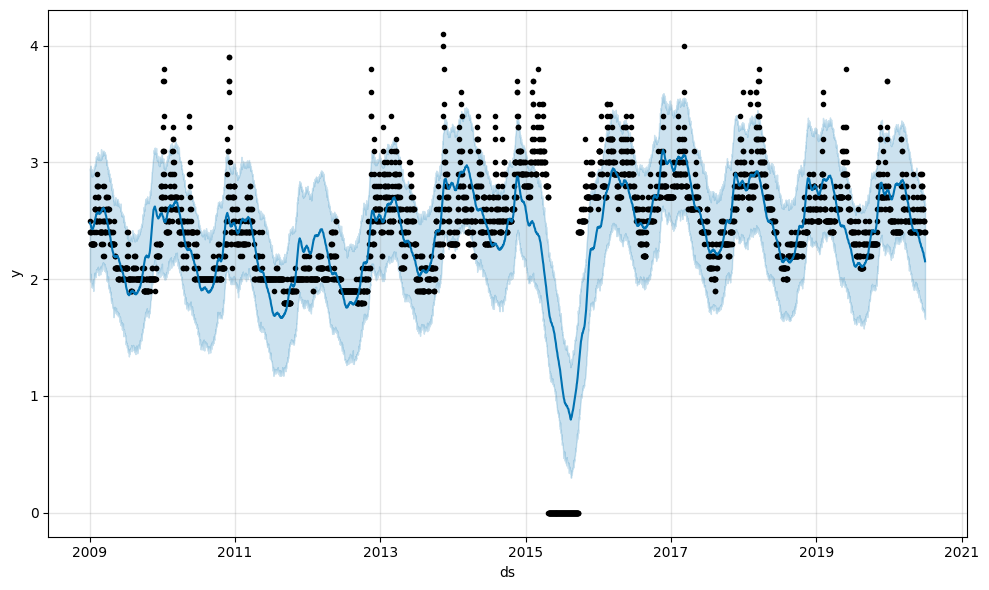

In [823]:
forecast,m = prediction_prophet('hydrometry', df)
fig = m.plot(forecast)

<Axes: xlabel='date', ylabel='hydrometry'>

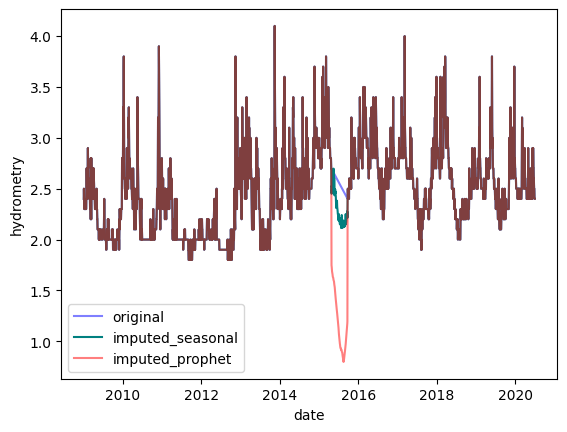

In [824]:

imputed_indices = new_df[new_df['hydrometry'].isnull()].index
new_df['hydrometry_prophet'] = new_df['hydrometry']
new_df.loc[imputed_indices, 'hydrometry_prophet'] = forecast['yhat'][imputed_indices]

sns.lineplot(x=df['date'],  y=new_df['hydrometry'],  color = 'blue', label = 'original', alpha = 0.5)
sns.lineplot(x=df['date'],  y=new_df['hydrometry_seasonal_decomp'],  color = 'teal', label = 'imputed_seasonal')
sns.lineplot(x=new_df['date'], y=new_df['hydrometry_prophet'] ,color='red', label = 'imputed_prophet', alpha = 0.5)

(16526.0, 16709.0)

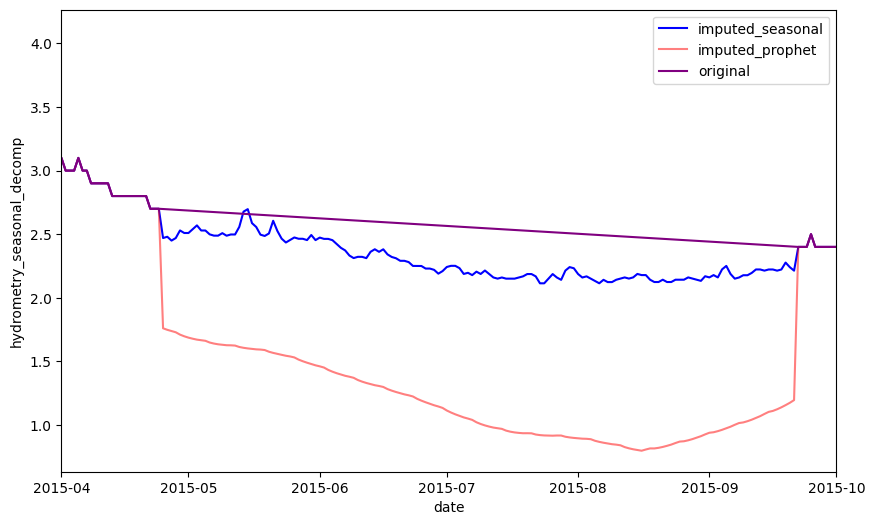

In [825]:
#zooming in
f, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x=df['date'],  y=new_df['hydrometry_seasonal_decomp'],  color = 'blue', label = 'imputed_seasonal')
sns.lineplot(x=df['date'], y=new_df['hydrometry_prophet'] , color='red', label = 'imputed_prophet', alpha = 0.5)
sns.lineplot(x=df['date'],  y=new_df['hydrometry'],  color = 'purple', label = 'original')

ax.set_xlim([date(2015, 4, 1), date(2015, 10, 1)])

We will now choose the best features as explored above

In [826]:
new_df.columns

Index(['date', 'rainfall_bastia', 'depth_to_gw', 'temp_bastia', 'temp_pet',
       'drainage_volume', 'hydrometry', 'depth_to_gw_interpolated',
       'drainage_volume_interpolated', 'drainage_volume_ffill',
       'temp_pet_seasonal_decomp', 'hydrometry_seasonal_decomp',
       'temp_pet_prophet', 'temp_pet_multi_prophet', 'hydrometry_prophet'],
      dtype='object')

In [827]:
df_final = new_df[['date', 'rainfall_bastia', 'depth_to_gw_interpolated', 'temp_bastia',
       'temp_pet_multi_prophet', 'drainage_volume_ffill',  'hydrometry_seasonal_decomp']].copy()

In [828]:
df_final

date  rainfall_bastia  depth_to_gw_interpolated  temp_bastia  \
0    2009-01-01              0.0                    -31.14          5.2   
1    2009-01-02              0.0                    -31.11          2.3   
2    2009-01-03              0.0                    -31.07          4.4   
3    2009-01-04              0.0                    -31.05          0.8   
4    2009-01-05              0.0                    -31.01         -1.9   
...         ...              ...                       ...          ...   
4194 2020-06-26              0.0                    -25.07         25.7   
4195 2020-06-27              0.0                    -25.11         26.2   
4196 2020-06-28              0.0                    -25.19         26.9   
4197 2020-06-29              0.0                    -25.18         26.9   
4198 2020-06-30              0.0                    -25.25         27.3   

     temp_pet_multi_prophet  drainage_volume_ffill hydrometry_seasonal_decomp  
0                       4.9             -24530.688                        2.4  
1                       2.5             -28785.888                        2.5  
2                       3.9             -25766.208                        2.4  
3                       0.8             -27919.296                        2.4  
4                      -2.1             -29854.656                        2.3  
...                     ...                    ...                        ...  
4194                   24.5             -29930.688                        2.5  
4195                   25.0             -31332.960                        2.4  
4196                   25.7             -32120.928                        2.4  
4197                   26.0             -30602.880                        2.4  
4198                   26.5             -31878.144                        2.4  

[4199 rows x 7 columns]

In [829]:
df_final.isna().sum()

date                          0
rainfall_bastia               0
depth_to_gw_interpolated      0
temp_bastia                   0
temp_pet_multi_prophet        0
drainage_volume_ffill         0
hydrometry_seasonal_decomp    0
dtype: int64

In [830]:
cols = ['date', 'rainfall_bastia', 'depth_to_gw', 'temp_bastia', 'temp_pet', 'drainage_volume', 'hydrometry']
df_final.columns = cols

In [831]:
df_final

date  rainfall_bastia  depth_to_gw  temp_bastia temp_pet  \
0    2009-01-01              0.0       -31.14          5.2      4.9   
1    2009-01-02              0.0       -31.11          2.3      2.5   
2    2009-01-03              0.0       -31.07          4.4      3.9   
3    2009-01-04              0.0       -31.05          0.8      0.8   
4    2009-01-05              0.0       -31.01         -1.9     -2.1   
...         ...              ...          ...          ...      ...   
4194 2020-06-26              0.0       -25.07         25.7     24.5   
4195 2020-06-27              0.0       -25.11         26.2     25.0   
4196 2020-06-28              0.0       -25.19         26.9     25.7   
4197 2020-06-29              0.0       -25.18         26.9     26.0   
4198 2020-06-30              0.0       -25.25         27.3     26.5   

      drainage_volume hydrometry  
0          -24530.688        2.4  
1          -28785.888        2.5  
2          -25766.208        2.4  
3          -27919.296        2.4  
4          -29854.656        2.3  
...               ...        ...  
4194       -29930.688        2.5  
4195       -31332.960        2.4  
4196       -32120.928        2.4  
4197       -30602.880        2.4  
4198       -31878.144        2.4  

[4199 rows x 7 columns]

###Seasonal Decomposition of Features

In [834]:
for column in cols[1:]:
    component = seasonal_decompose(df_final[column], period=52, model='additive', extrapolate_trend='freq')
    df_final[f"{column}_trend"] = component.trend
    df_final[f"{column}_seasonal"] = component.seasonal
    df_final[f"{column}_resid"] = component.resid

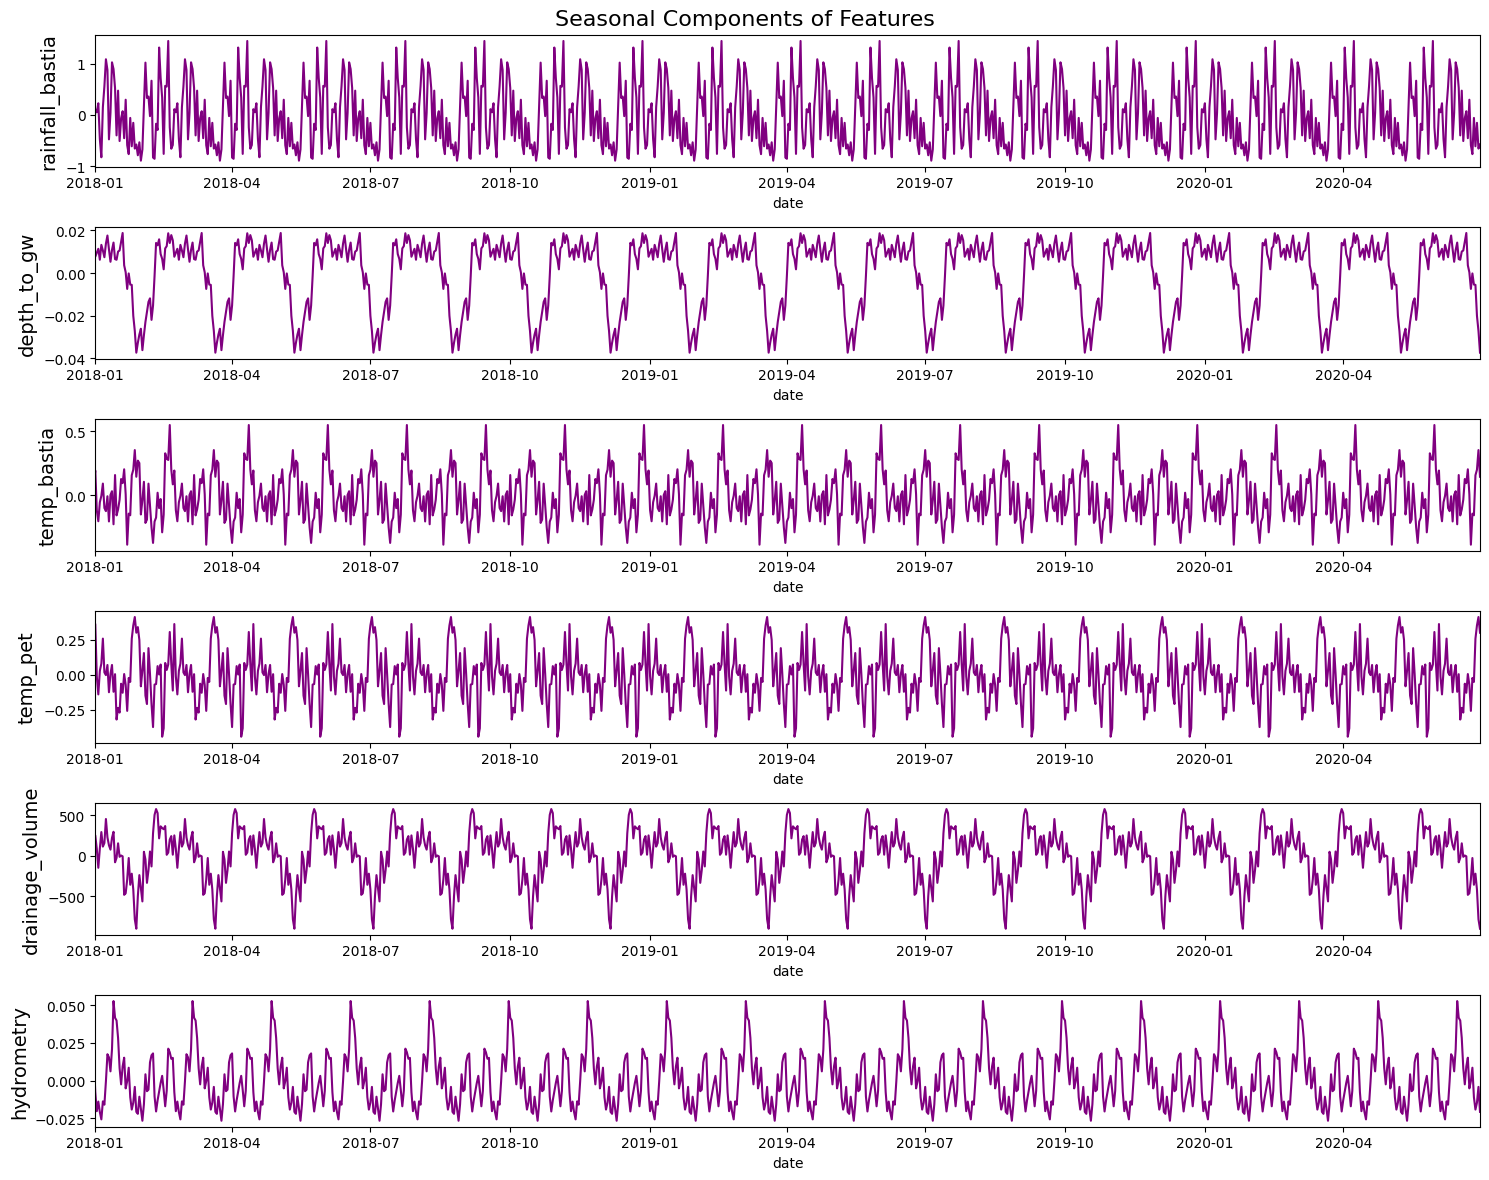

In [835]:

f, ax = plt.subplots(nrows=6, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(cols[1:]):
    sns.lineplot(x=df_final['date'], y=df_final[column + '_seasonal'], ax=ax[i], color='purple')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2018, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

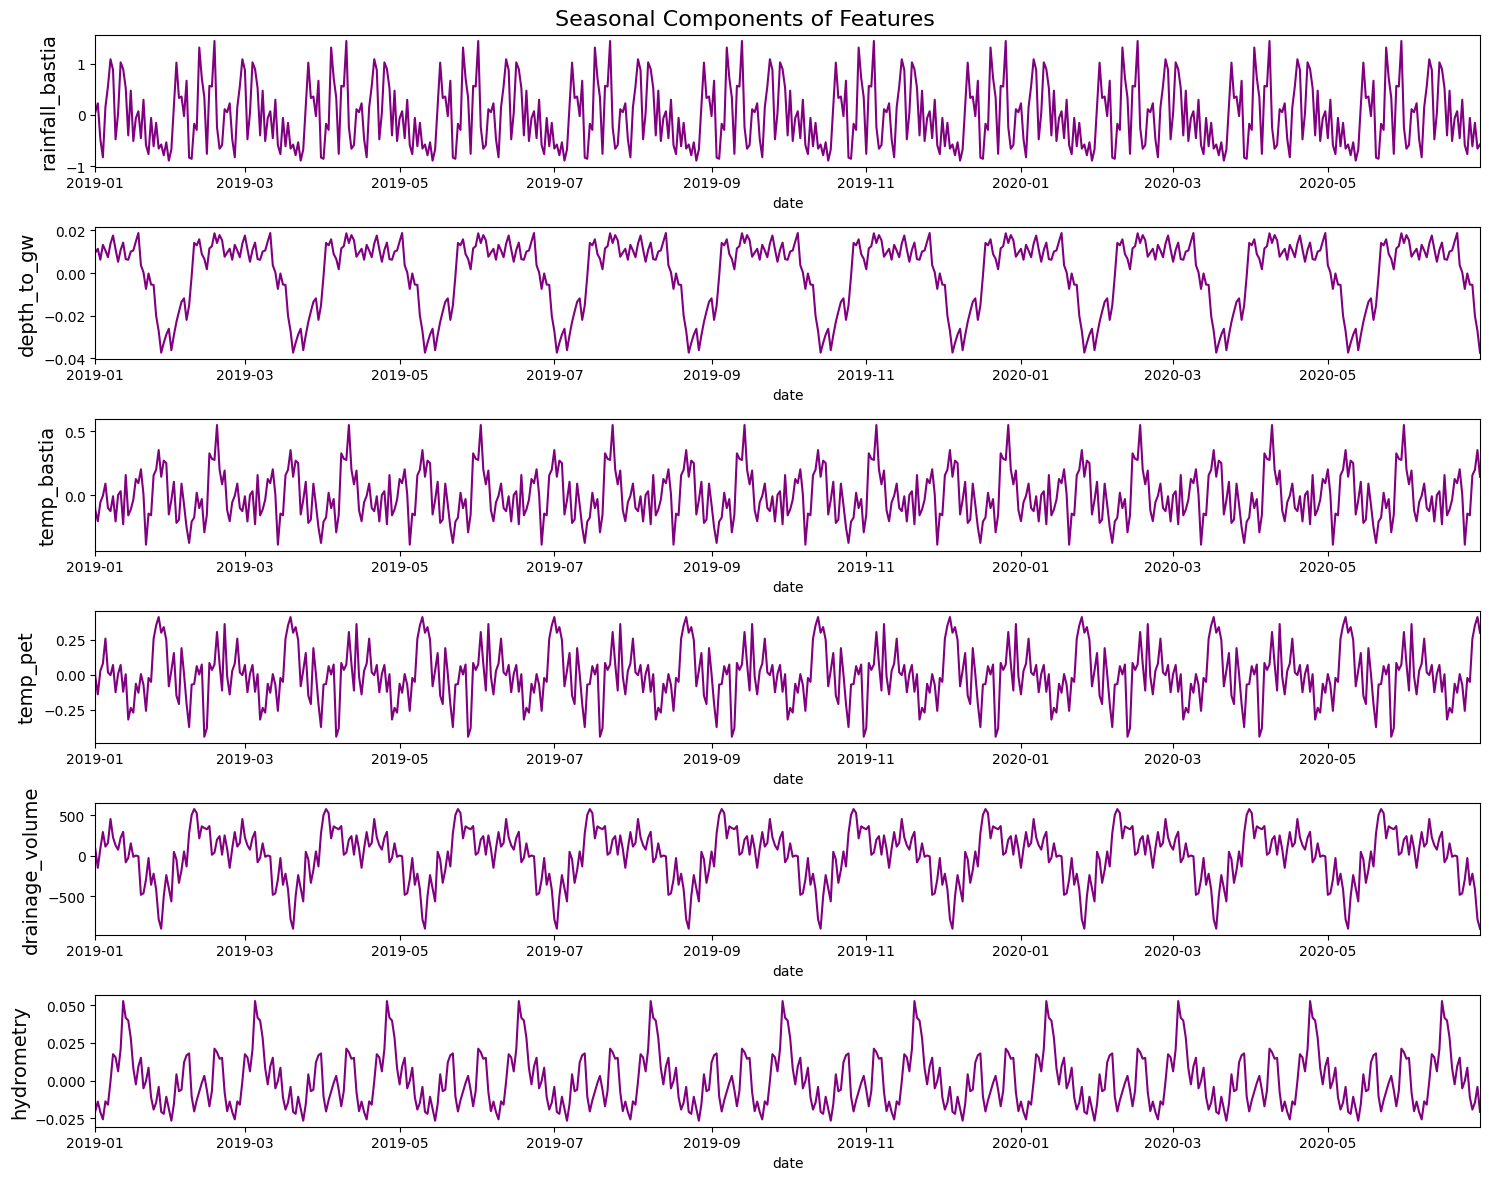

In [836]:
#zooming in
f, ax = plt.subplots(nrows=6, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(cols[1:]):
    sns.lineplot(x=df_final['date'], y=df_final[column + '_seasonal'], ax=ax[i], color='purple')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2019, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

We can observe the annual high and low points, and cycles for each of the features.


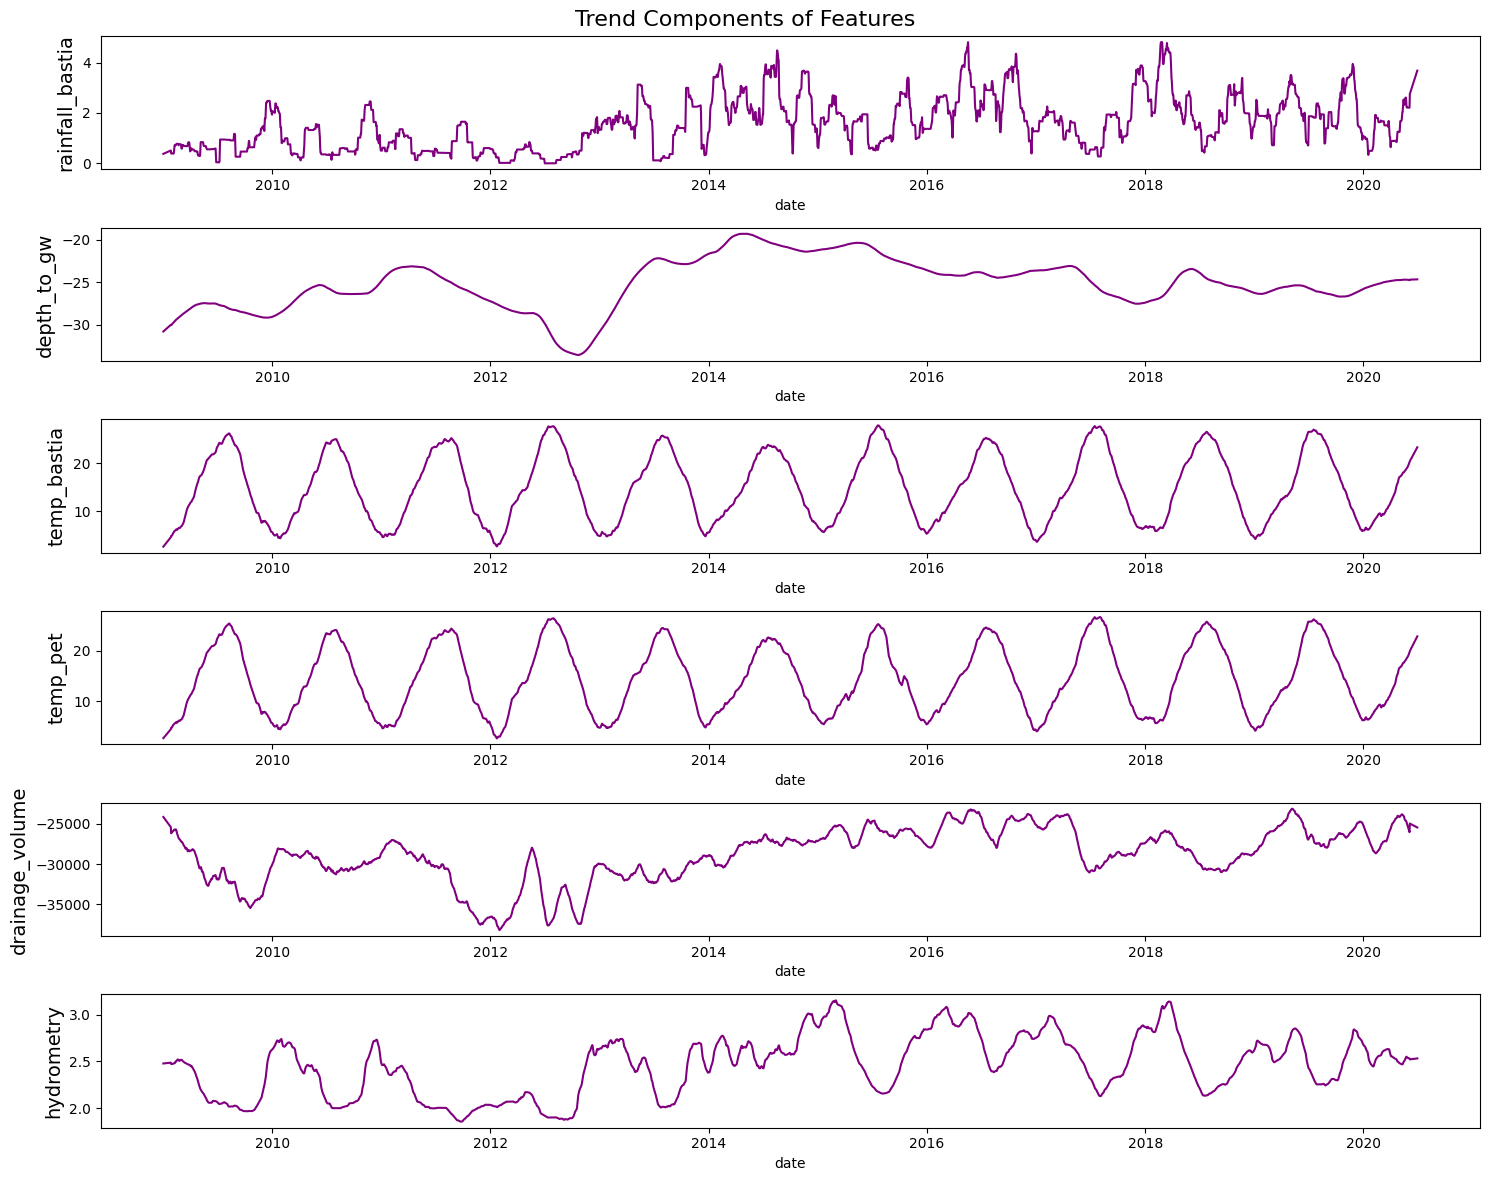

In [837]:
f, ax = plt.subplots(nrows=6, ncols=1, figsize=(15, 12))
f.suptitle('Trend Components of Features', fontsize=16)

for i, column in enumerate(cols[1:]):
    sns.lineplot(x=df_final['date'], y=df_final[column + '_trend'], ax=ax[i], color='purple')
    ax[i].set_ylabel(ylabel=column, fontsize=14)


plt.tight_layout()
plt.show()

In [838]:
# Extracting date components and adding to the DataFrame
df_final['year'] = pd.DatetimeIndex(df_final['date']).year
df_final['month'] = pd.DatetimeIndex(df_final['date']).month
df_final['day'] = pd.DatetimeIndex(df_final['date']).day
df_final['day_of_year'] = pd.DatetimeIndex(df_final['date']).dayofyear
df_final['week_of_year'] = df_final['date'].dt.isocalendar().week
df_final['quarter'] = pd.DatetimeIndex(df_final['date']).quarter
df_final['season'] = df_final['month'] % 12 // 3 + 1

df_final[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']]

date  year  month  day  day_of_year  week_of_year  quarter  season
0    2009-01-01  2009      1    1            1             1        1       1
1    2009-01-02  2009      1    2            2             1        1       1
2    2009-01-03  2009      1    3            3             1        1       1
3    2009-01-04  2009      1    4            4             1        1       1
4    2009-01-05  2009      1    5            5             2        1       1
...         ...   ...    ...  ...          ...           ...      ...     ...
4194 2020-06-26  2020      6   26          178            26        2       3
4195 2020-06-27  2020      6   27          179            26        2       3
4196 2020-06-28  2020      6   28          180            26        2       3
4197 2020-06-29  2020      6   29          181            27        2       3
4198 2020-06-30  2020      6   30          182            27        2       3

[4199 rows x 8 columns]

###Anomaly Detection with ARIMA

[ARIMA Model for Time Series Forecasting](https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/)

ARIMA stands for autoregressive integrated moving average model and is specified by three order parameters: (p, d, q).

* (AR(p)) component refers to the use of past values in the regression equation for the time series.
* I(d) Integration – uses differencing of observations (subtracting an observation from observation at the previous time step) in order to make the time series stationary. Differencing involves the subtraction of the current values of a series with its previous values d number of times.
*MA(q) Moving Average – a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. A moving average component depicts the error of the model as a combination of previous error terms. The order q represents the number of terms to be included in the model.



To check for stationarity, i.e the that mean and variance of the data does not change with time. We use the ADFuller Statistic to see if the data is stationary.

In [877]:
from statsmodels.tsa.stattools import adfuller


In [345]:
def check_stationarity(data, i):
    result = adfuller(data)
    ADF_Statistic, p_value = result[0], result[1]
    if p_value < 0.05 and ADF_Statistic <= result[4]['1%'] and ADF_Statistic <= result[4]['5%'] and ADF_Statistic <= result[4]['10%']:
        print(f"The {i} time series is stationary")
        return True
    else:
        print(f"The {i} time series is not stationary")
        return False



In [347]:
for i in cols[1:]:
  check_stationarity(df_final[i], i)

The rainfall_bastia time series is stationary
The depth_to_gw time series is not stationary
The temp_bastia time series is stationary
The temp_pet time series is stationary
The drainage_volume time series is stationary
The hydrometry time series is stationary


The target feature, depth to ground water is not stationary. Let's plot a rolling mean and std. We see that both measures change overtime

<Axes: xlabel='date', ylabel='depth_to_gw'>

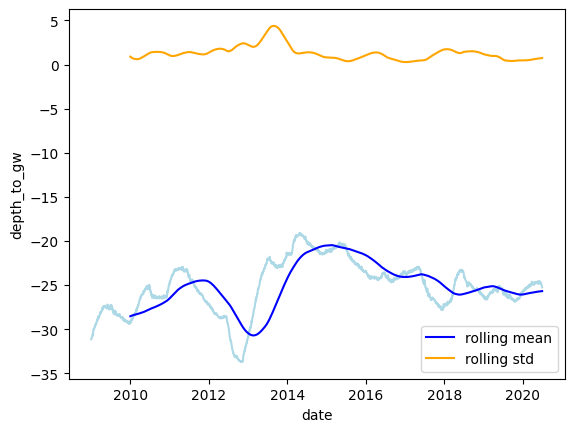

In [839]:
rolling_window = 365
f, ax = plt.subplots()
sns.lineplot(x=df['date'], y=df_final['depth_to_gw'],color='lightblue')
sns.lineplot(x=df['date'], y=df_final['depth_to_gw'].rolling(rolling_window).mean(), color='blue', label='rolling mean')
sns.lineplot(x=df['date'], y=df_final['depth_to_gw'].rolling(rolling_window).std(), color='orange', label='rolling std')

Let's also see an example of a stationary time series. As expected, the rolling mean stays more or less constant

<Axes: xlabel='date', ylabel='temp_bastia'>

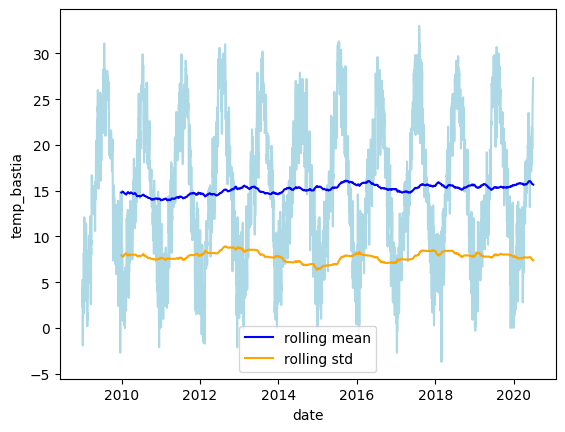

In [840]:
rolling_window = 365
f, ax = plt.subplots()
sns.lineplot(x=df_final['date'], y=df_final['temp_bastia'],color='lightblue')
sns.lineplot(x=df_final['date'], y=df_final['temp_bastia'].rolling(rolling_window).mean(), color='blue', label='rolling mean')
sns.lineplot(x=df_final['date'], y=df_final['temp_bastia'].rolling(rolling_window).std(), color='orange', label='rolling std')

Next, we will transform the depth_to_gw so that it becomes stationary. We do this by differencing, i.e taking a rolling difference between consecutive data points.
* For First order differencing, the rolling window is 1:  
${d_i} = x_i - x_{i-1}$

The depth_to_gw_diff time series is stationary


<Axes: xlabel='date', ylabel='depth_to_gw_diff'>

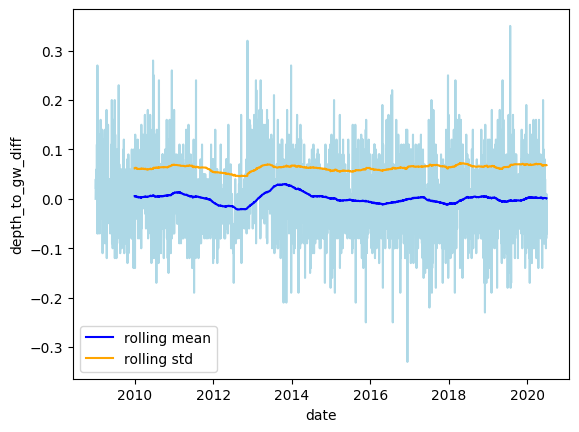

In [841]:
# First Order Differencing
ts_diff = np.diff(df_final['depth_to_gw'])

#appending 0 because we cannot compute this for the first value
df_final['depth_to_gw_diff'] = np.append([0], ts_diff)
check_stationarity(df_final['depth_to_gw_diff'], 'depth_to_gw_diff')

rolling_window = 365
f, ax = plt.subplots()
sns.lineplot(x=df_final['date'], y=df_final['depth_to_gw_diff'],color='lightblue')
sns.lineplot(x=df_final['date'], y=df_final['depth_to_gw_diff'].rolling(rolling_window).mean(), color='blue', label='rolling mean')
sns.lineplot(x=df_final['date'], y=df_final['depth_to_gw_diff'].rolling(rolling_window).std(), color='orange', label='rolling std')

So first order diffrerncing is suffiecient. Using Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to find the remaining ARIMA parameters.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

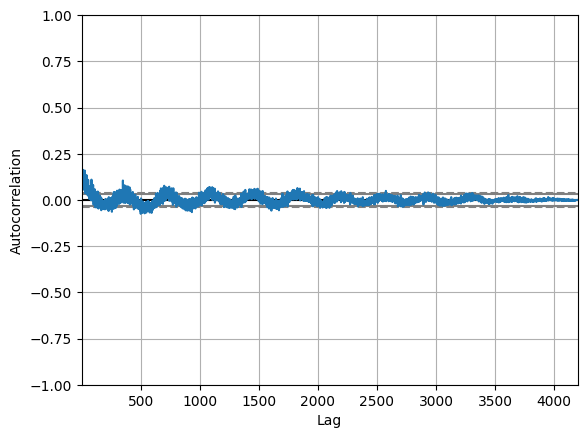

In [846]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_final['depth_to_gw_diff'])

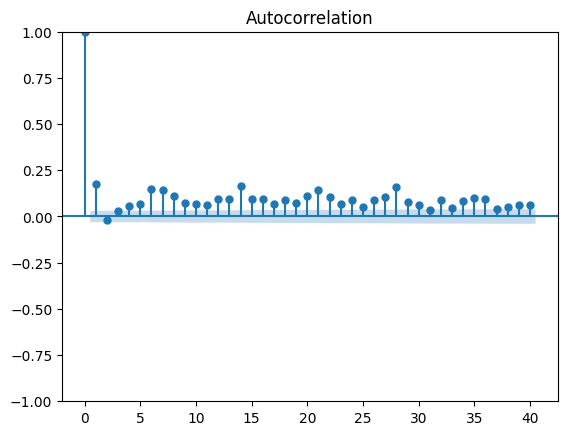

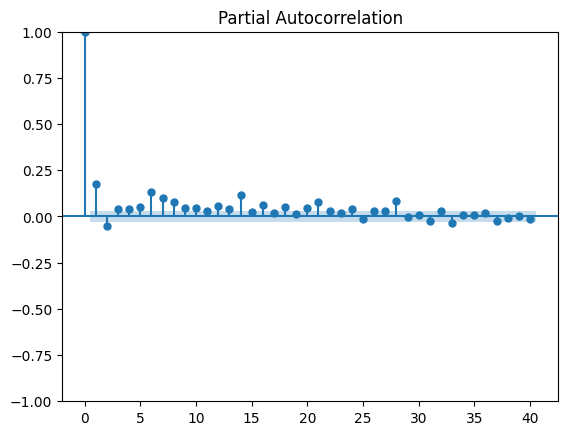

In [842]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_final['depth_to_gw_diff'], lags=40)
plot_pacf(df_final['depth_to_gw_diff'], lags=40)
plt.show()

In [847]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Fit model
model = ARIMA(df_final['depth_to_gw'][1:], order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred = model_fit.forecast(len(df_final['depth_to_gw'][1:]))
y_pred.index = df_final['depth_to_gw'][1:].index
# Calcuate metrics
score_mae = mean_absolute_error(df_final['depth_to_gw'][1:], y_pred)
score_rmse = math.sqrt(mean_squared_error(df_final['depth_to_gw'][1:], y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 2.9529784227869222


In [848]:
std = np.std(y_pred - df_final['depth_to_gw'])

In [849]:
anomalies = df_final[abs(y_pred - df_final['depth_to_gw']) > score_mae + std]

In [850]:
len(anomalies)

312

<Axes: xlabel='date', ylabel='depth_to_gw'>

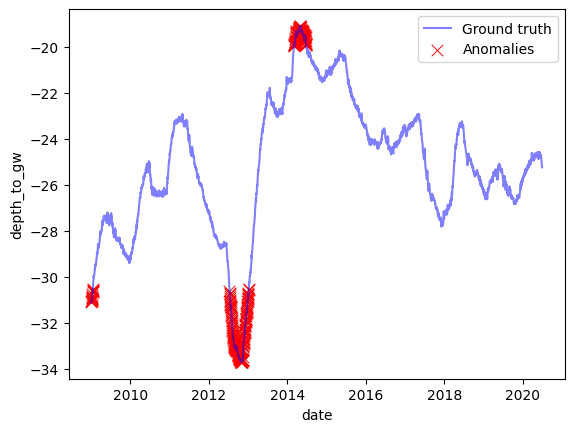

In [858]:
f, ax = plt.subplots()
sns.lineplot(x=df_final['date'], y=df_final['depth_to_gw'], color='blue', alpha = 0.5, label='Ground truth')
sns.scatterplot(x = anomalies['date'], y = anomalies['depth_to_gw'],  color='red', marker = 'x',  label='Anomalies', s = 70)



Now we will try using multivariate prophet for anomaly detection in target feature.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp498x7ro7/ltu9ci3k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp498x7ro7/ge42w2e9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69410', 'data', 'file=/tmp/tmp498x7ro7/ltu9ci3k.json', 'init=/tmp/tmp498x7ro7/ge42w2e9.json', 'output', 'file=/tmp/tmp498x7ro7/prophet_modelqc_mcft1/prophet_model-20240510081314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:13:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:13:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


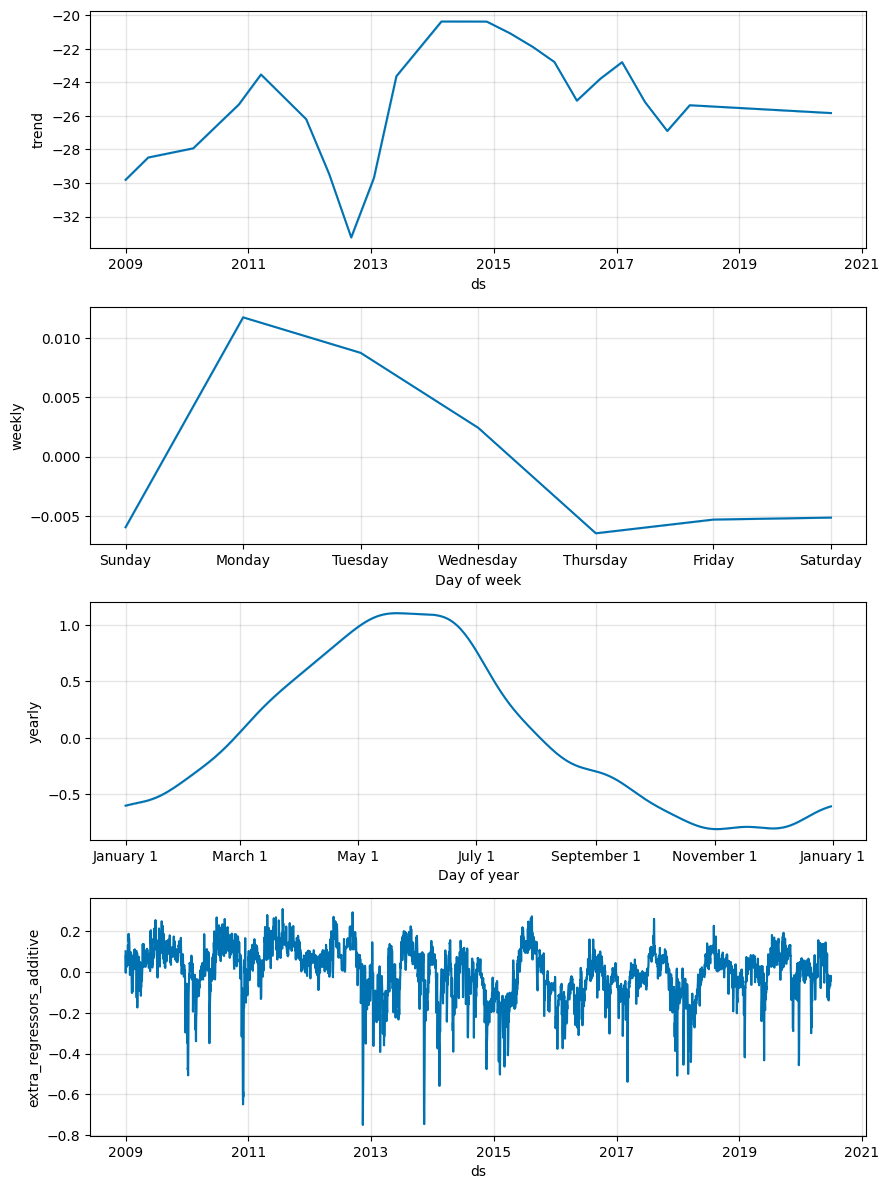

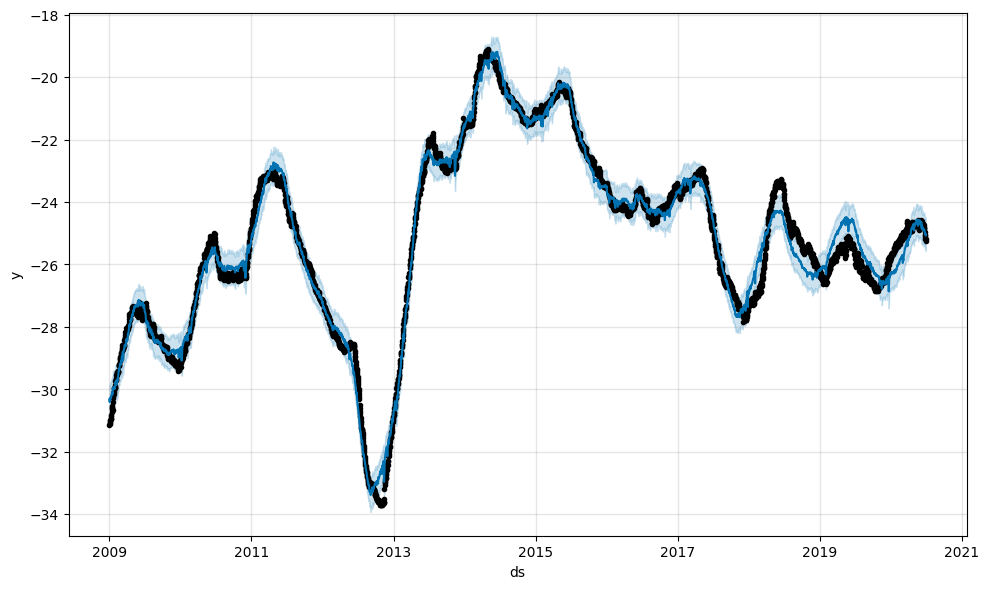

In [859]:
features = [
 'rainfall_bastia',
 'temp_bastia',
 'temp_pet',
 'drainage_volume',
 'hydrometry']

forecast,m = prediction_multi_prophet(features, 'depth_to_gw', df_final)
fig = m.plot_components(forecast)
fig = m.plot(forecast)


Surprisingly, there is also a weekly trend to depth to ground water, indicating that water is pulled out more on Monday- Thursday

In [860]:

mae = np.mean(abs(df_final['depth_to_gw'] - forecast['yhat']))
std = np.std(abs(df_final['depth_to_gw'] - forecast['yhat']))
print(f"Score RMSE: {score_rmse} \nMAE Score: {mae}")
mae = mean_absolute_error(df_final['depth_to_gw'], forecast['yhat'])
score_rmse = math.sqrt(mean_squared_error(df_final['depth_to_gw'], forecast['yhat']))
diff_upper = abs(df_final['depth_to_gw'] - forecast['yhat_upper'])
diff_lower = abs(df_final['depth_to_gw'] -  forecast['yhat_lower'])
df_min  = np.minimum(diff_upper, diff_lower)



anomalies = df_final[df_min > 1.5*score_rmse]
print(len(anomalies))


Score RMSE: 2.9529784227869222 
MAE Score: 0.30464838407349243
35


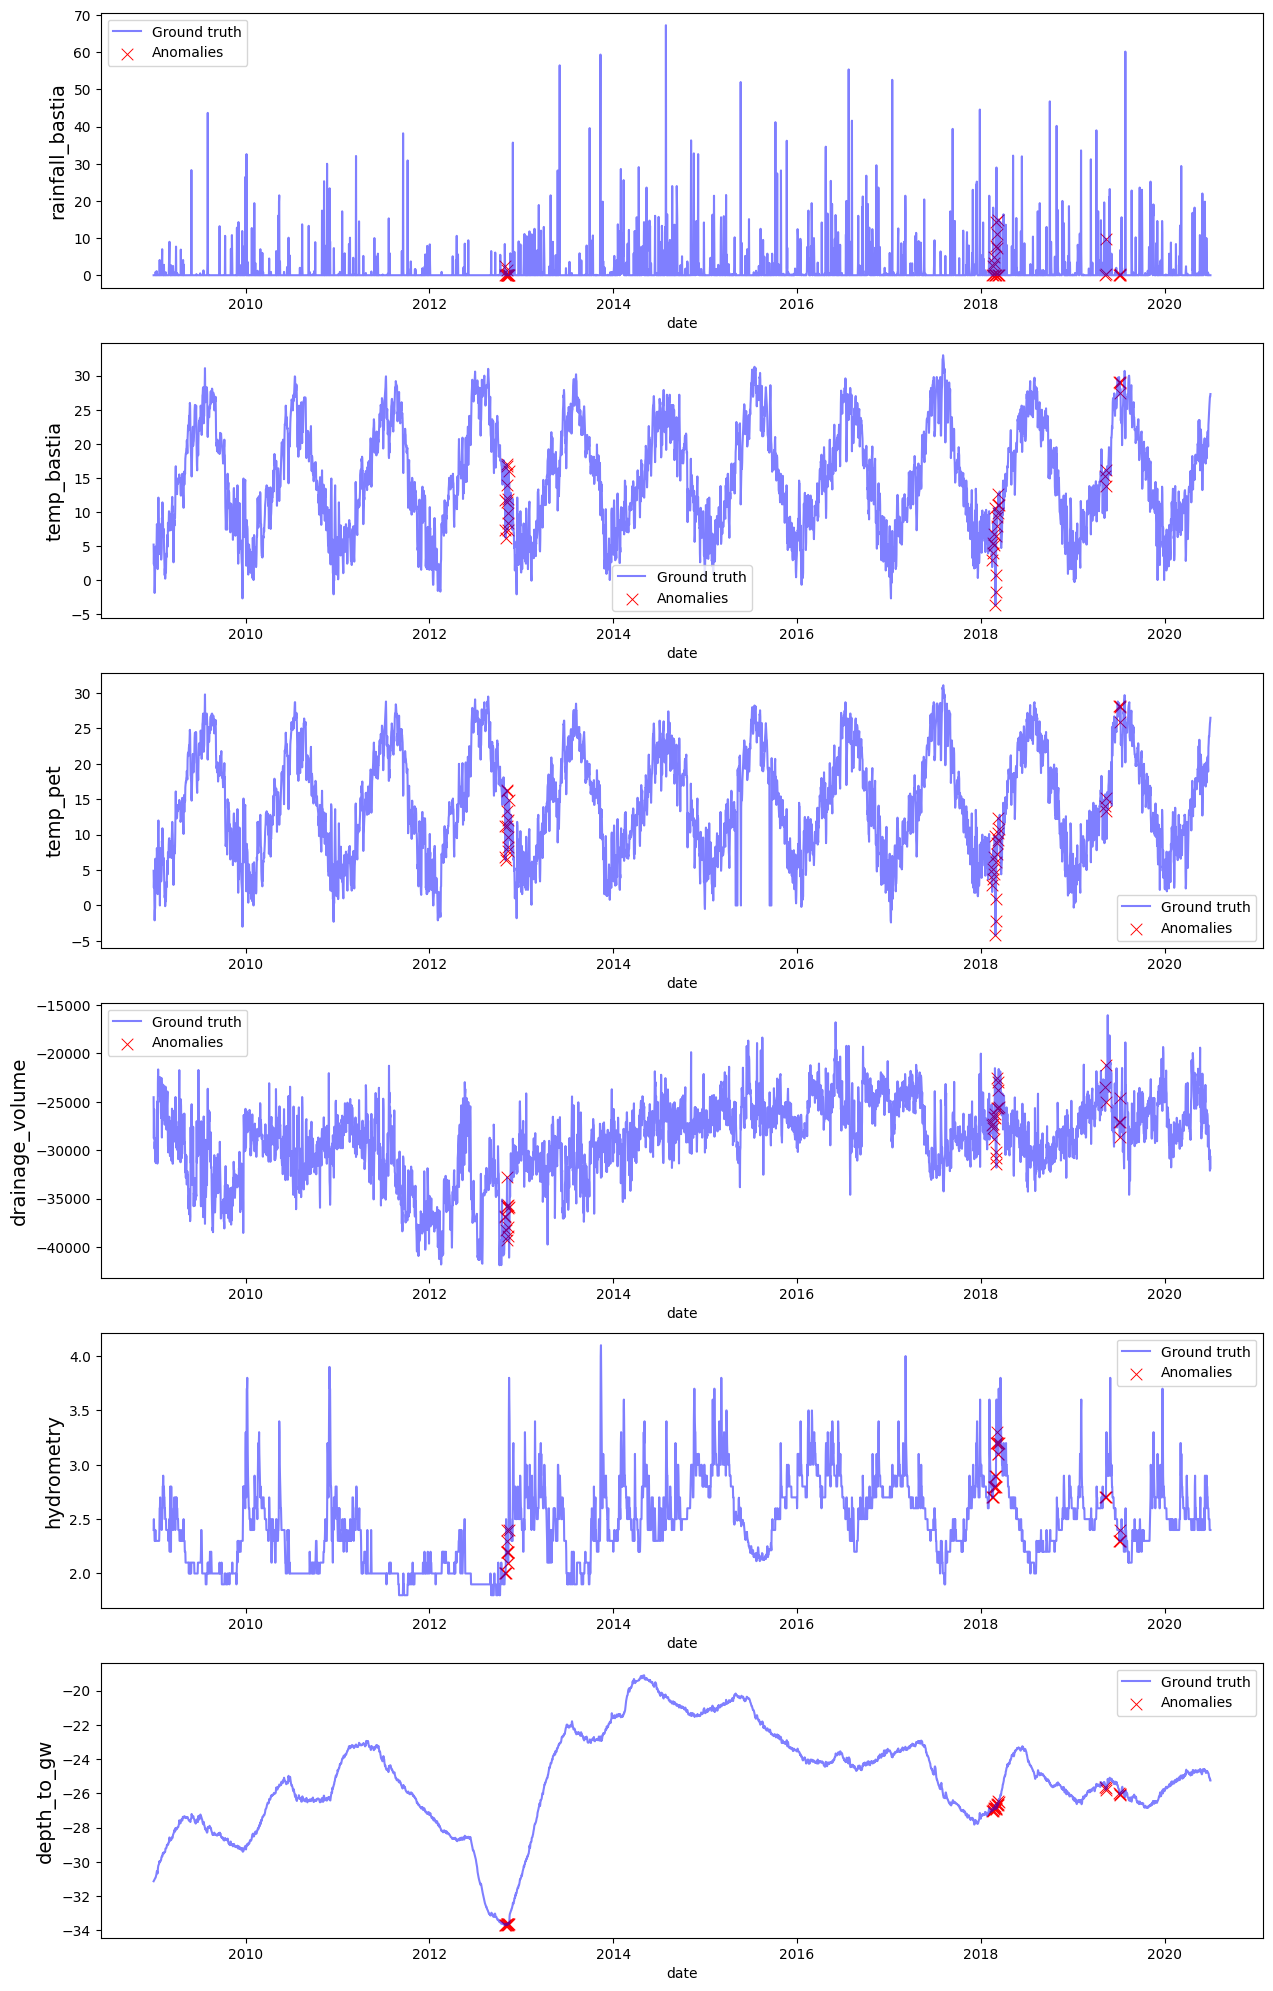

In [861]:

f, ax = plt.subplots(nrows=len(features)+1, ncols=1, figsize=(15, 25))
i = 0
for col in features + ['depth_to_gw']:
    sns.lineplot(x=df_final['date'], y=df_final[col], ax=ax[i], color='blue', alpha = 0.5, label='Ground truth')
    sns.scatterplot(x = anomalies['date'], y = anomalies[col],  ax=ax[i], color='red', marker = 'x',  label='Anomalies', s = 70)

    ax[i].set_ylabel(ylabel=col, fontsize=14)
    i+=1

Now we will use [Isolation Forest](https://www.analyticsvidhya.com/blog/2021/07/anomaly-detection-using-isolation-forest-a-complete-guide/), a technique that is specifc to identifying outliers in a high dimensional space (and so it can handle multiple variables)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


60


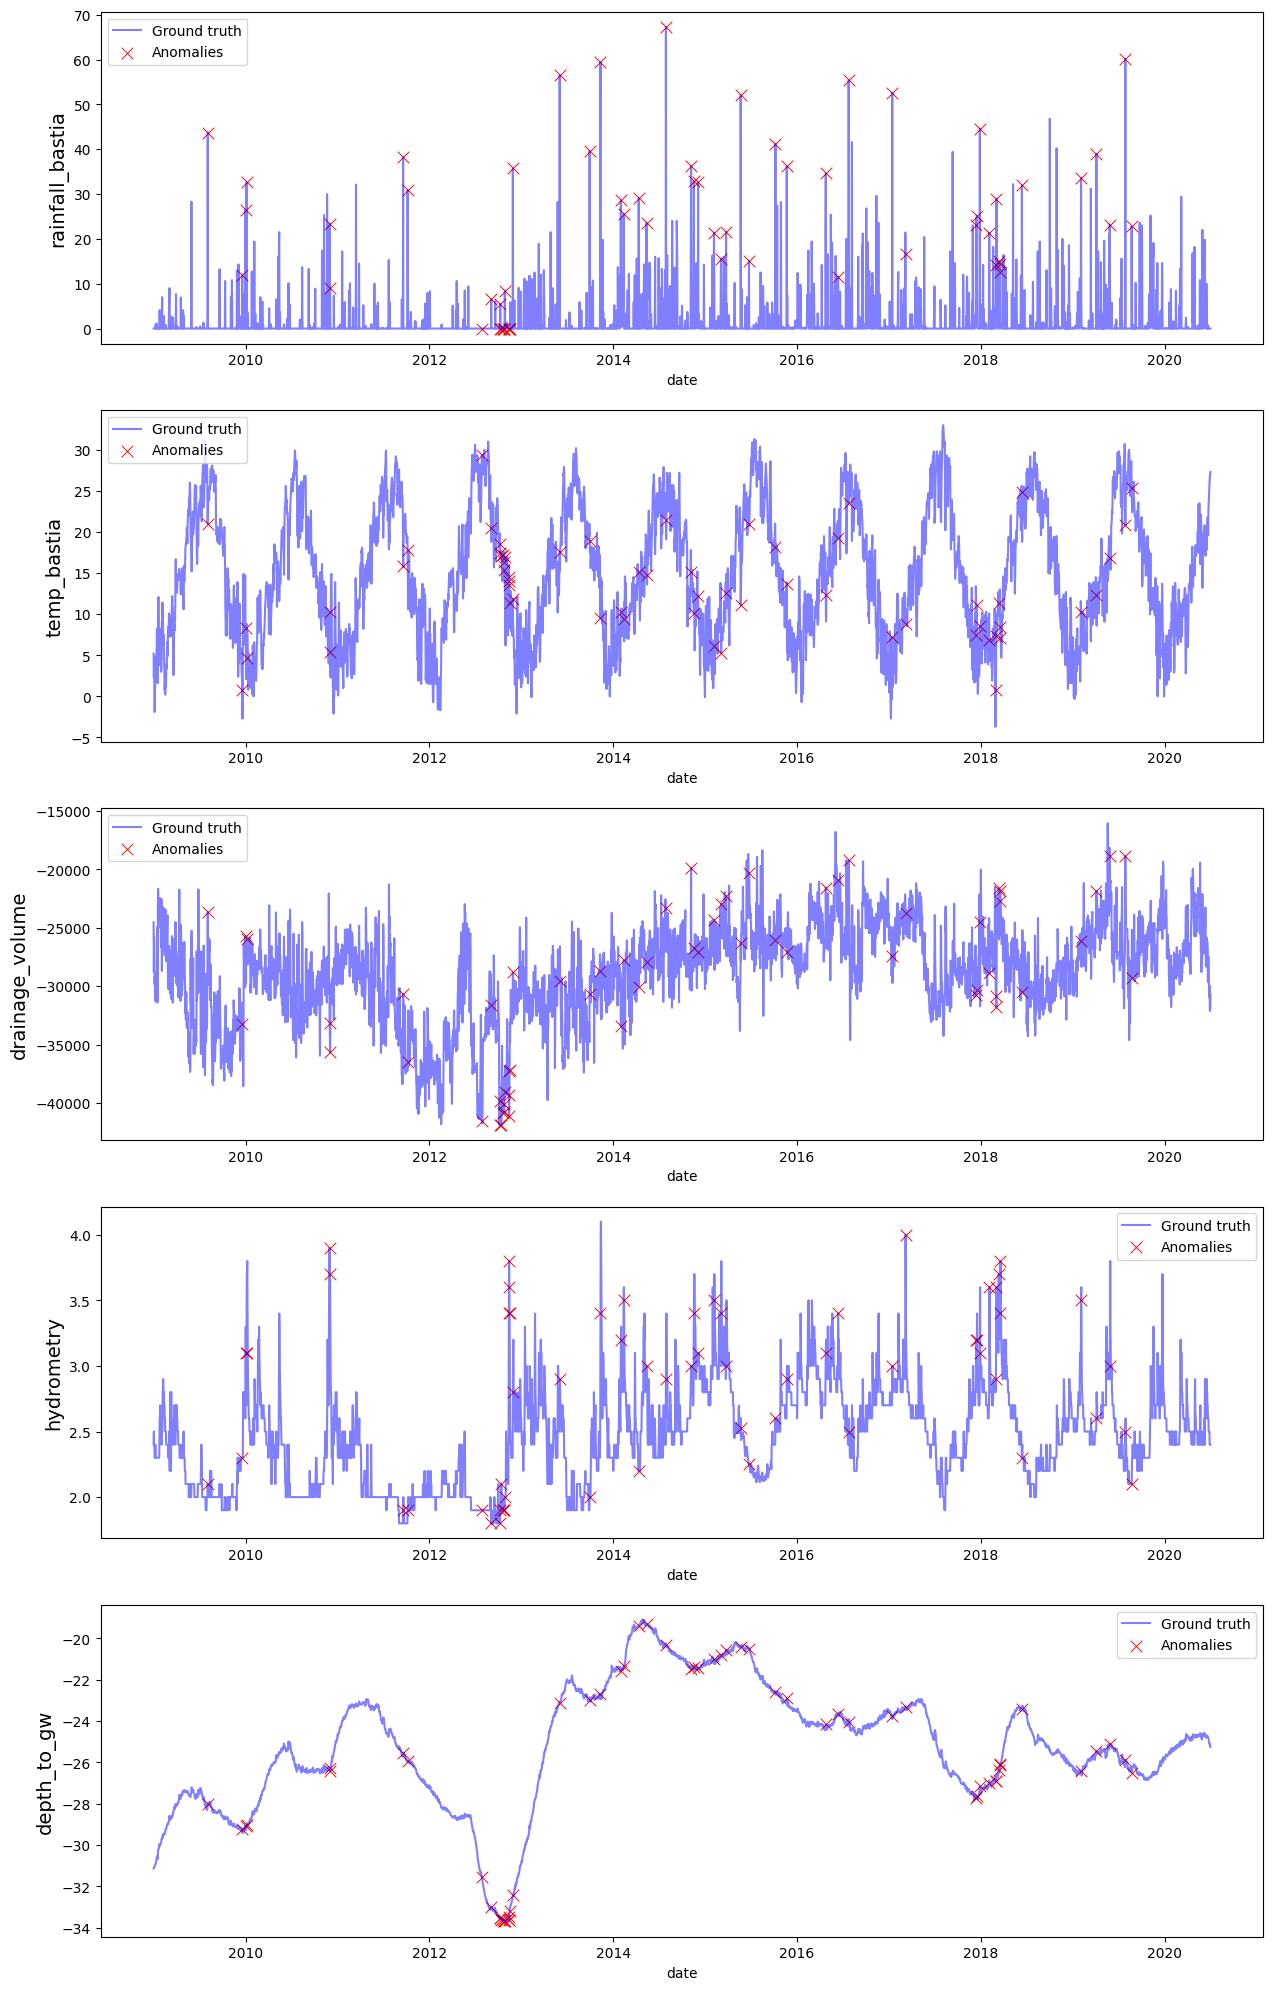

In [731]:
target = 'depth_to_gw'
features = ['rainfall_bastia','temp_bastia','drainage_volume','hydrometry']

from pyod.models.iforest import IForest
iforest = IForest().fit(df_final[features + [target]])
# Generate probabilities
probs = iforest.predict_proba(df_final[features + [target]])
# Isolate the outliers
is_outlier = probs[:, 1] > 0.75
anomalies = df_final[is_outlier]
print(len(anomalies))


f, ax = plt.subplots(nrows=len(features)+1, ncols=1, figsize=(15, 25))
i = 0
for col in features + [target]:
    sns.lineplot(x=df_final['date'], y=df_final[col], ax=ax[i], color='blue', alpha = 0.5, label='Ground truth')
    sns.scatterplot(x = anomalies['date'], y = anomalies[col],  ax=ax[i], color='red', marker = 'x',  label='Anomalies', s = 70)

    ax[i].set_ylabel(ylabel=col, fontsize=14)
    i+=1



Reducing/Experimenting with the features will give us better results

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


107


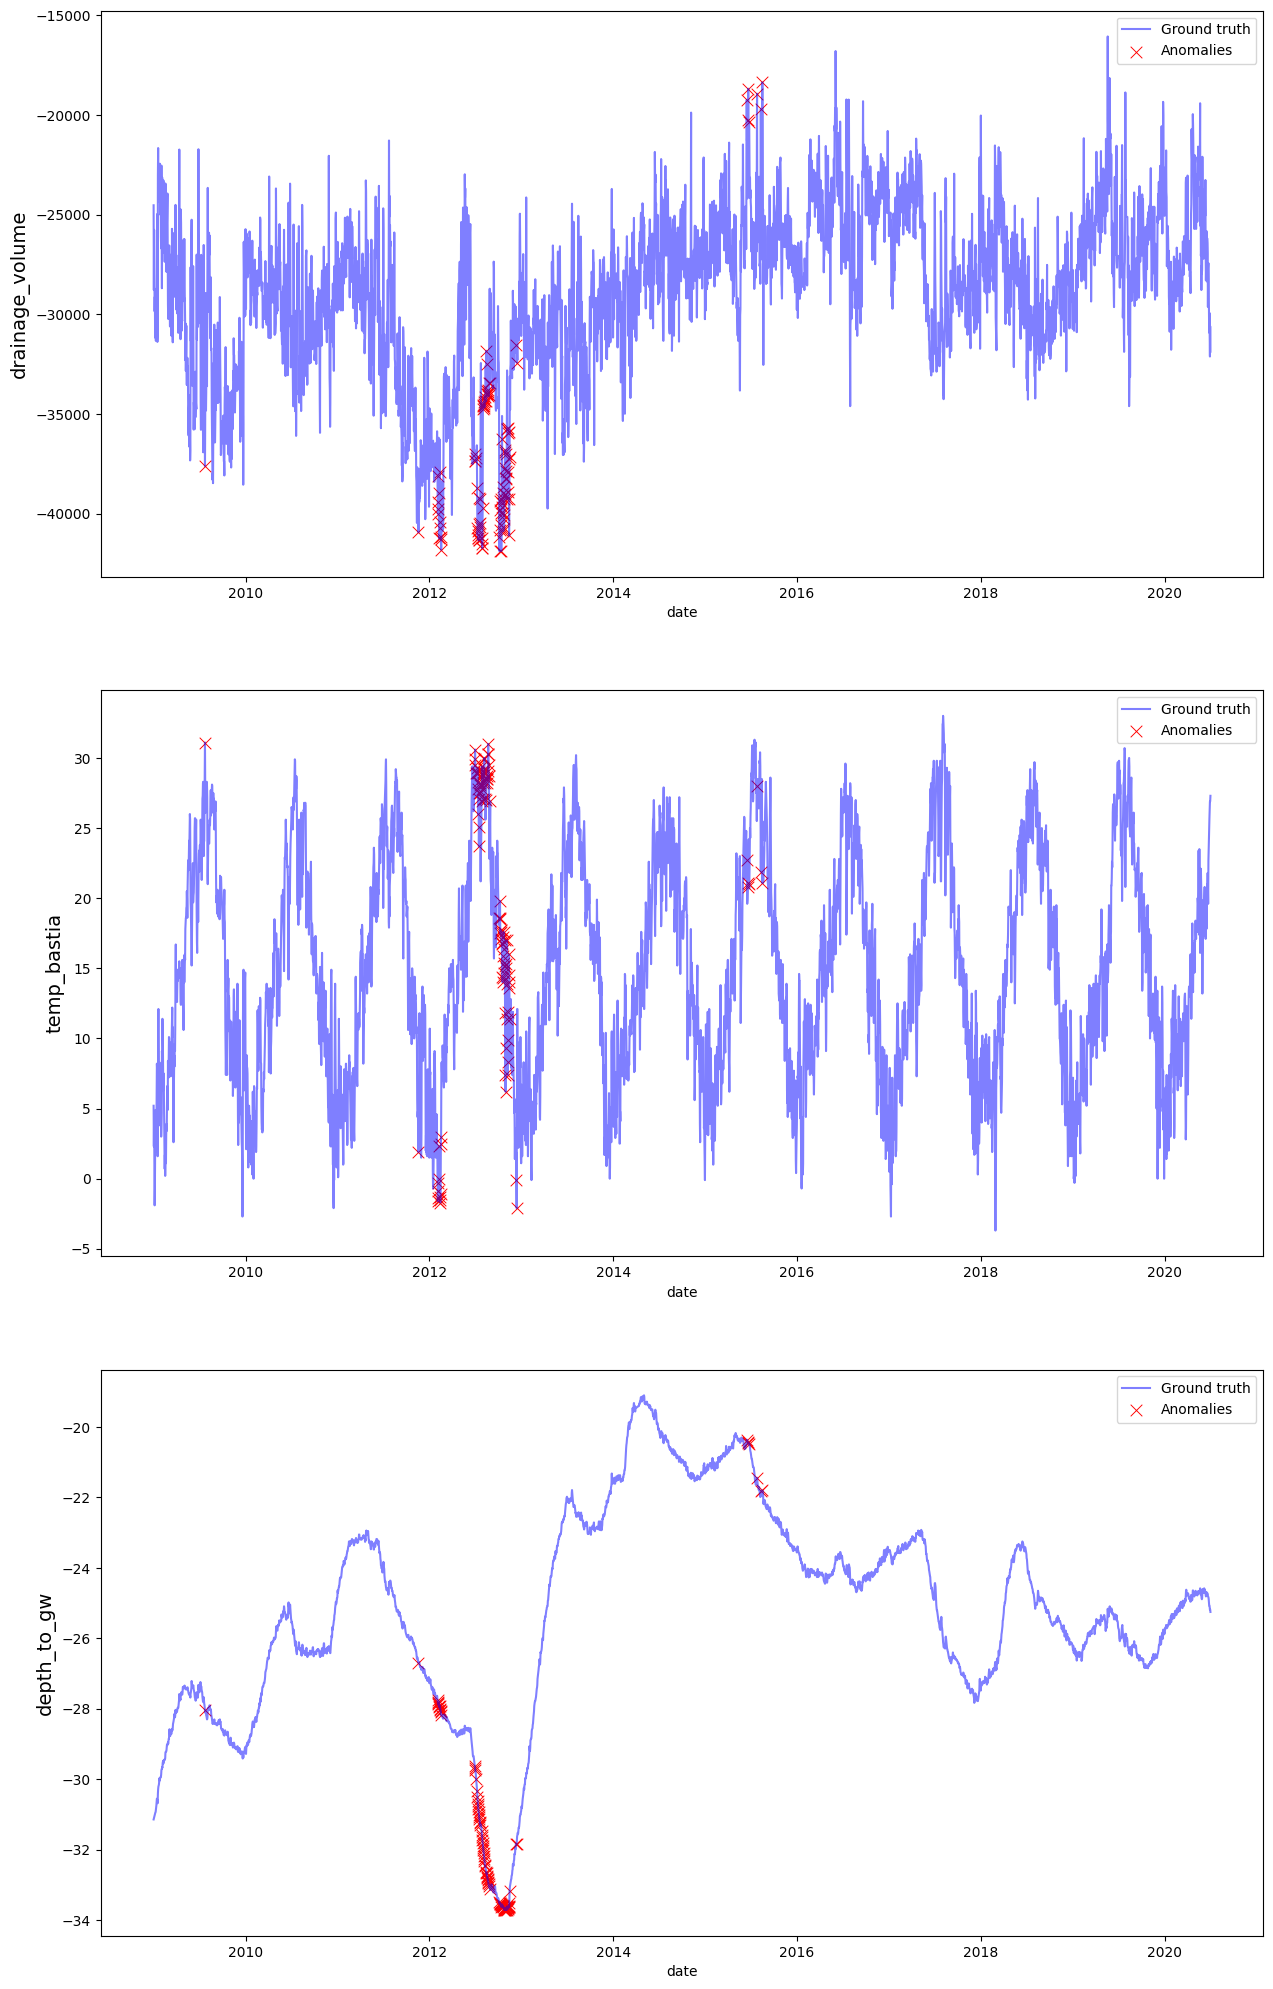

In [868]:
target = 'depth_to_gw'
features = ['drainage_volume','temp_bastia']

from pyod.models.iforest import IForest
iforest = IForest().fit(df_final[features + [target]])
# Generate probabilities
probs = iforest.predict_proba(df_final[features + [target]])
# Isolate the outliers
is_outlier = probs[:, 1] > 0.75
anomalies = df_final[is_outlier]
print(len(anomalies))


f, ax = plt.subplots(nrows=len(features)+1, ncols=1, figsize=(15, 25))
i = 0
for col in features + [target]:
    sns.lineplot(x=df_final['date'], y=df_final[col], ax=ax[i], color='blue', alpha = 0.5, label='Ground truth')
    sns.scatterplot(x = anomalies['date'], y = anomalies[col],  ax=ax[i], color='red', marker = 'x',  label='Anomalies', s = 70)

    ax[i].set_ylabel(ylabel=col, fontsize=14)
    i+=1



To improve the features further, we will look at correlations. Here we note that both rainfall and temperature don't affect the depth to groundwater and hydrometry on the same date but some time after. This time is not known.

In [869]:
df_shifts = df_final.copy()
for column in cols[1:]:
  for i in range(8)[1:]:
    df_shifts[f'{column}_{i}d'] = df_shifts[column].shift(i)
  for i in range(5)[1:]:
    df_shifts[f'{column}_{i}w'] = df_shifts[column].shift(i*7)
  for i in range(5)[1:]:
    df_shifts[f'{column}_{i}m'] = df_shifts[column].shift(i*30)
  for i in range(8)[1:]:
    df_shifts[f'{column}_seasonal_{i}d'] = df_shifts[f'{column}_seasonal'].shift(i)
  for i in range(5)[1:]:
    df_shifts[f'{column}_seasonal_{i}w'] = df_shifts[f'{column}_seasonal'].shift(i*7)
  for i in range(5)[1:]:
    df_shifts[f'{column}_seasonal_{i}m'] = df_shifts[f'{column}_seasonal'].shift(i*30)

<ipython-input-869-82ebb21d1d02>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_shifts[f'{column}_{i}d'] = df_shifts[column].shift(i)
<ipython-input-869-82ebb21d1d02>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_shifts[f'{column}_{i}w'] = df_shifts[column].shift(i*7)
<ipython-input-869-82ebb21d1d02>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

In [870]:
shifted_cols_drainage = [i for i in df_shifts.columns if "drainage" in i]
shifted_cols_hydrometry = [i for i in df_shifts.columns if "hydrometry" in i]
shifted_cols_rainfall_bastia = [i for i in df_shifts.columns if "rainfall_bastia" in i]
shifted_cols_temp_pet = [i for i in df_shifts.columns if "temp_pet" in i]
shifted_cols_temp_bastia = [i for i in df_shifts.columns if "temp_bastia" in i]

In [871]:
shifted_lst = [shifted_cols_drainage, shifted_cols_hydrometry, shifted_cols_rainfall_bastia, shifted_cols_temp_pet, shifted_cols_temp_bastia]

In [872]:
max_corr_col_list = []
for shifted_feature_list in shifted_lst:
  # Compute the correlation matrix for the specified columns
  corr_mat = df_shifts.corr()

  # Initialize variables to store the maximum correlation and corresponding column name
  max_corr_value = 0
  max_corr_col = None


  # Iterate over the columns and their correlation values with 'depth_to_gw_seasonal'
  for col in shifted_feature_list:
      corr_value = corr_mat['depth_to_gw'][col]
      print(f"Correlation of {col}': {corr_value}")

      # Check if the current correlation value is the maximum encountered so far
      if abs(corr_value) > abs(max_corr_value) and abs(corr_value) < 1:
          max_corr_value = corr_value
          max_corr_col = col

  # Print the column with the highest correlation
  print(f"Column with highest correlation to 'depth_to_gw': {max_corr_col} (Correlation: {max_corr_value}) \n")
  max_corr_col_list.append(max_corr_col)

Correlation of drainage_volume': 0.4222081522462708
Correlation of drainage_volume_trend': 0.48704683314031216
Correlation of drainage_volume_seasonal': 0.0004486653519251643
Correlation of drainage_volume_resid': 0.03440872173692985
Correlation of drainage_volume_1d': 0.4235328723617631
Correlation of drainage_volume_2d': 0.42318714225514137
Correlation of drainage_volume_3d': 0.4235394618137004
Correlation of drainage_volume_4d': 0.42407649013002285
Correlation of drainage_volume_5d': 0.42492166278844795
Correlation of drainage_volume_6d': 0.42619021445129485
Correlation of drainage_volume_7d': 0.42759337202757286
Correlation of drainage_volume_1w': 0.42759337202757286
Correlation of drainage_volume_2w': 0.433095689940232
Correlation of drainage_volume_3w': 0.439450825200078
Correlation of drainage_volume_4w': 0.4441985164985134
Correlation of drainage_volume_1m': 0.4443556852343377
Correlation of drainage_volume_2m': 0.44589388593922374
Correlation of drainage_volume_3m': 0.43123122

In [873]:
max_corr_col_list

['drainage_volume_trend',
 'hydrometry_3m',
 'rainfall_bastia_trend',
 'temp_pet_4m',
 'temp_bastia_4m']

In [874]:
max_corr_col_list_seasonal = []
for shifted_feature_list in shifted_lst:
  # Compute the correlation matrix for the specified columns
  corr_mat = df_shifts.corr()

  # Initialize variables to store the maximum correlation and corresponding column name
  max_corr_value = 0
  max_corr_col = None


  # Iterate over the columns and their correlation values with 'depth_to_gw_seasonal'
  for col in shifted_feature_list:
      corr_value = corr_mat['depth_to_gw_seasonal'][col]
      print(f"Correlation of {col}': {corr_value}")

      # Check if the current correlation value is the maximum encountered so far
      if abs(corr_value) > abs(max_corr_value) and abs(corr_value) < 1:
          max_corr_value = corr_value
          max_corr_col = col

  # Print the column with the highest correlation
  print(f"Column with highest correlation to 'depth_to_gw_seasonal': {max_corr_col} (Correlation: {max_corr_value}) \n")
  max_corr_col_list_seasonal.append(max_corr_col)

Correlation of drainage_volume': 0.059264264358044424
Correlation of drainage_volume_trend': 0.0038086564010933197
Correlation of drainage_volume_seasonal': 0.6868795680297543
Correlation of drainage_volume_resid': 8.136054035146289e-17
Correlation of drainage_volume_1d': 0.06430214645995153
Correlation of drainage_volume_2d': 0.0630041662747834
Correlation of drainage_volume_3d': 0.060809240883788425
Correlation of drainage_volume_4d': 0.06102039492631812
Correlation of drainage_volume_5d': 0.057556041282160346
Correlation of drainage_volume_6d': 0.056925163430490124
Correlation of drainage_volume_7d': 0.05693084117535199
Correlation of drainage_volume_1w': 0.05693084117535199
Correlation of drainage_volume_2w': 0.006331652727445511
Correlation of drainage_volume_3w': -0.0271420670138548
Correlation of drainage_volume_4w': -0.02534516975073397
Correlation of drainage_volume_1m': -0.028144340901274767
Correlation of drainage_volume_2m': 0.05448994997437303
Correlation of drainage_volum

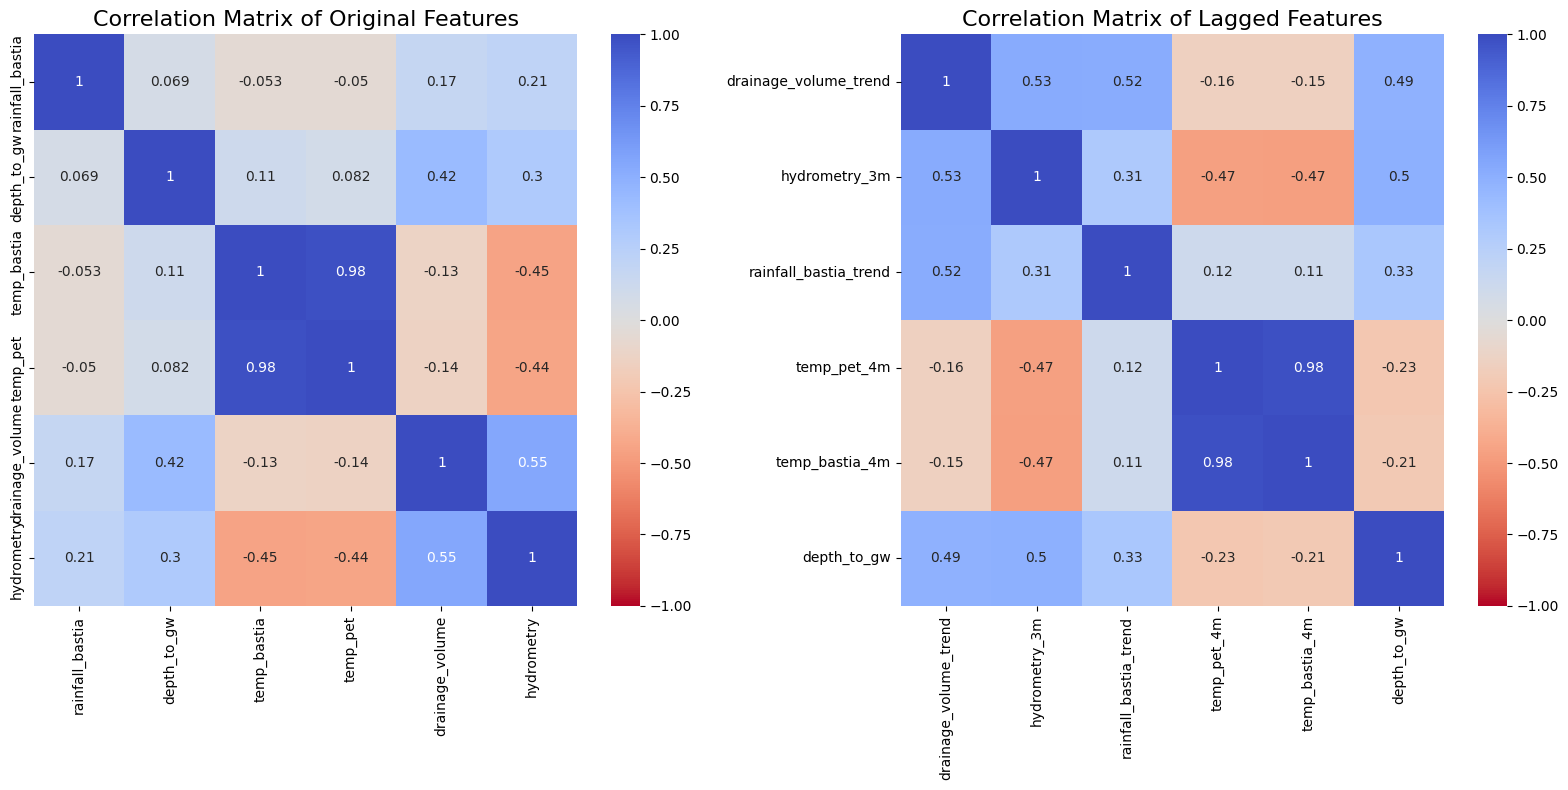

In [875]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corr_mat = df_final[cols[1:]].corr()

sns.heatmap(corr_mat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Original Features', fontsize=16)

shifted_cols = max_corr_col_list

corr_mat = df_shifts[shifted_cols+ ['depth_to_gw']].corr()

sns.heatmap(corr_mat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)

plt.tight_layout()
plt.show()

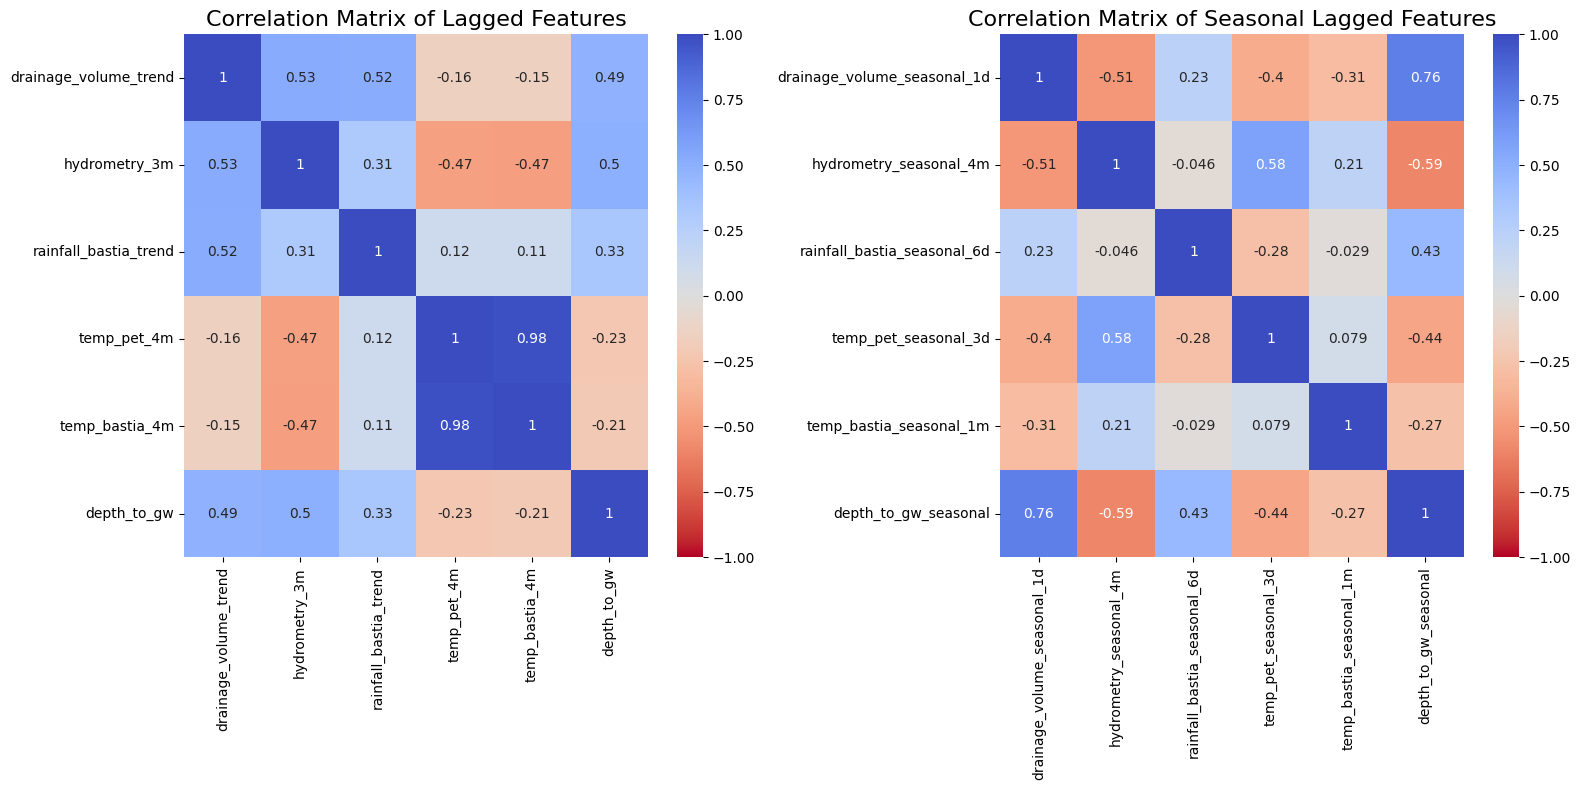

In [876]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

shifted_cols = max_corr_col_list

corr_mat = df_shifts[shifted_cols+ ['depth_to_gw']].corr()

sns.heatmap(corr_mat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Lagged Features', fontsize=16)


shifted_cols = max_corr_col_list_seasonal

corr_mat = df_shifts[shifted_cols+ ['depth_to_gw_seasonal']].corr()

sns.heatmap(corr_mat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Seasonal Lagged Features', fontsize=16)

plt.tight_layout()
plt.show()

We can observe that the correlation with depth_to_gw is much stronger with lagged features than the original, and that the depth_to_gw_seasonal also has a high correlation with the seasonal laggged feaetures selected.

In summary, in this notebook we first identified and filled in the corrupt data in the covariate data, and then inffered the correct value. In addition we also attempted to find anomalies and extreme values in the target variable using univariate and multivariate models.

The next steps in this exercise will be to use lagged features in the multivariate models for anomaly detection and prediction.
We can also upsample the frequency from daily to weekly and then compute the lagged features on a monthly/weekly level.

